In [15]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from matplotlib.patches import Patch
import textwrap
import os # Importar os para manejo de directorios
import re # Importar re para expresiones regulares (útil en parsing)
import warnings

# --- Configuraciones y Constantes ---
warnings.filterwarnings('ignore') # Ignorar advertencias (usar con precaución)

# Archivos y Directorios
INPUT_CSV = 'analisisTodos.csv'
OUTPUT_DIR = 'obj04Res' # Nombre de la carpeta de salida

# Nombres de Columnas Relevantes (ajustar si son diferentes en el CSV)
COL_CAPACITACION_DISENO = 'Factores Contextuales: Capacitación y Diseño Instruccional'
COL_SOCIOECONOMICO = 'Factores Contextuales: Factores Socioeconómicos y Personales'
COL_HERRAMIENTAS = 'Herramientas Digitales: Tipos de Herramientas Interactivas'
COL_EFECTO = 'Effect Sizes'
COL_ANIO = 'Year'

# Palabras Clave para Factores (en minúsculas)
FACTOR_KEYWORDS = {
    'Teacher Training': ['teacher training', 'formación docente', 'capacitación docente'],
    'Instructional Design': ['design', 'instructional', 'diseño instruccional'],
    'Scaffolding': ['scaffolding', 'andamiaje'],
    'Support Features': ['support', 'apoyo'],
    'SES Factors': ['ses', 'socioeconomic', 'socioeconómico'],
    'Family Support': ['family', 'parent', 'familia', 'padres'],
    'Access Issues': ['access', 'connectivity', 'acceso', 'conectividad'],
    'Prior Knowledge': ['prior knowledge', 'conocimiento previo']
}

# Palabras Clave para Tipos de Herramientas (en minúsculas)
TOOL_KEYWORDS = {
    'Games': ['game', 'juego', 'gamification'],
    'Software': ['software', 'platform', 'plataforma'],
    'AR/VR': ['ar', 'vr', 'realidad aumentada', 'realidad virtual'],
    'Adaptive': ['adaptive', 'adaptativo'],
    'Multimedia': ['multimedia', 'interactive'],
    'Mobile': ['mobile', 'móvil', 'tablet']
}

# Configuración de Estilo de Gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl") # Paleta de colores agradable
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.facecolor'] = 'white' # Fondo blanco para guardar
plt.rcParams['savefig.facecolor'] = 'white'

# --- Funciones de Preprocesamiento ---

def parse_effect_size(effect_text):
    """
    Intenta extraer un valor numérico (preferiblemente d de Cohen) del texto del tamaño del efecto.
    Retorna np.nan si no se puede parsear.
    """
    if pd.isna(effect_text):
        return np.nan
    
    text = str(effect_text).lower().replace(',', '.') # Normalizar texto

    # Buscar d=valor
    match_d = re.search(r'd\s*=\s*(-?\d+\.?\d*)', text)
    if match_d:
        try:
            return float(match_d.group(1))
        except ValueError:
            pass

    # Buscar valores negativos con sigma o sd (aproximación muy simple)
    match_neg = re.search(r'-\s*(\d+\.?\d*)\s*(?:σ|sd)', text)
    if match_neg:
        try:
             # Esto es una heurística, podría no ser -d. Usamos valor negativo pequeño como indicador.
            return -float(match_neg.group(1)) # Retornar el valor negativo
        except ValueError:
             return -0.2 # Valor por defecto si no se puede parsear el número

    # Buscar r=valor y convertir a d (d = 2r / sqrt(1 - r^2))
    match_r = re.search(r'r\s*=\s*(-?\d+\.?\d*)', text)
    if match_r:
        try:
            r = float(match_r.group(1))
            if abs(r) < 1:
                return 2 * r / np.sqrt(1 - r**2)
            else: # Evitar división por cero si r = 1 o -1
                return np.sign(r) * np.inf # O un valor grande finito
        except (ValueError, ZeroDivisionError):
            pass
            
    # Buscar η² o eta squared y convertir a d (d = 2 * sqrt(eta² / (1 - eta²)))
    match_eta = re.search(r'(?:η\s*2|eta\s*sq(?:uared)?)\s*=\s*(\d+\.?\d*)', text)
    if match_eta:
        try:
            eta_sq = float(match_eta.group(1))
            if 0 <= eta_sq < 1:
                 return 2 * np.sqrt(eta_sq / (1 - eta_sq))
            elif eta_sq == 1:
                 return np.inf # O un valor grande finito
        except (ValueError, ZeroDivisionError):
            pass

    # Si no se encuentra nada reconocible
    return np.nan

def categorize_effect_value(d_value):
    """Categoriza un valor d de Cohen numérico."""
    if pd.isna(d_value):
        return 'Not Reported' #'No Reportado'
    elif d_value > 0.8:
        return 'Large' #'Grande'
    elif d_value > 0.5:
        return 'Medium' #'Mediano'
    elif d_value >= 0: # Incluye 0 como pequeño
        return 'Small' #'Pequeño'
    else: # d_value < 0
        return 'Negative' #'Negativo'

def assign_tool_type(tool_text):
    """Asigna un tipo de herramienta basado en palabras clave."""
    if pd.isna(tool_text):
        return 'Otro/No especificado'
    text = str(tool_text).lower()
    for tool_name, keywords in TOOL_KEYWORDS.items():
        if any(keyword in text for keyword in keywords):
            return tool_name
    return 'Otro/No especificado'

def load_and_preprocess_data(filepath):
    """Carga el CSV y realiza el preprocesamiento."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Error: El archivo de entrada '{filepath}' no se encontró.")

    print(f"Cargando datos desde: {filepath}")
    df = pd.read_csv(filepath, sep=';', encoding='utf-8')
    print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")

    # 1. Limpiar Año (convertir a numérico, manejar errores)
    df[COL_ANIO] = pd.to_numeric(df[COL_ANIO], errors='coerce').astype('Int64') # Usar Int64 para permitir NaNs

    # 2. Crear columnas booleanas para factores contextuales
    print("Procesando factores contextuales...")
    for factor_name, keywords in FACTOR_KEYWORDS.items():
        col_name = f'Factor_{factor_name.replace(" ", "_")}'
        # Determinar la columna de origen correcta
        if factor_name in ['Teacher Training', 'Instructional Design', 'Scaffolding', 'Support Features']:
            source_col = COL_CAPACITACION_DISENO
        else:
            source_col = COL_SOCIOECONOMICO
            
        if source_col in df.columns:
            df[col_name] = df[source_col].str.contains('|'.join(keywords), case=False, na=False, regex=True)
        else:
            print(f"Advertencia: Columna de origen '{source_col}' no encontrada para factor '{factor_name}'. Creando columna de False.")
            df[col_name] = False


    # 3. Parsear y categorizar tamaño del efecto
    print("Procesando tamaños de efecto...")
    if COL_EFECTO in df.columns:
      df['Effect_Value_d'] = df[COL_EFECTO].apply(parse_effect_size)
      df['Effect_Category'] = df['Effect_Value_d'].apply(categorize_effect_value)
    else:
      print(f"Advertencia: Columna '{COL_EFECTO}' no encontrada. Creando columnas de efecto vacías.")
      df['Effect_Value_d'] = np.nan
      df['Effect_Category'] = 'No Reportado'

    # 4. Asignar tipo de herramienta
    print("Procesando tipos de herramienta...")
    if COL_HERRAMIENTAS in df.columns:
      df['Tool_Type'] = df[COL_HERRAMIENTAS].apply(assign_tool_type)
    else:
      print(f"Advertencia: Columna '{COL_HERRAMIENTAS}' no encontrada. Asignando 'Otro/No especificado'.")
      df['Tool_Type'] = 'Otro/No especificado'
      
    print("Preprocesamiento completado.")
    # Imprimir resumen de columnas creadas
    new_cols = [f'Factor_{fn.replace(" ", "_")}' for fn in FACTOR_KEYWORDS] + ['Effect_Value_d', 'Effect_Category', 'Tool_Type']
    print("\nResumen del DataFrame preprocesado:")
    print(df[new_cols + [COL_ANIO]].info())
    print("\nDistribución de categorías de efecto:")
    print(df['Effect_Category'].value_counts())
    print("\nDistribución de tipos de herramienta:")
    print(df['Tool_Type'].value_counts())

    return df

# --- Funciones de Visualización (Modificadas para usar df preprocesado) ---

def create_factor_network(df, factor_cols):
    """Crea un gráfico de red mostrando la co-ocurrencia de factores contextuales"""
    print("Generando: Red de Co-ocurrencia de Factores...")
    fig, ax = plt.subplots(figsize=(12, 10))

    # Usar solo las columnas de factores booleanos existentes en el df
    valid_factor_cols = [col for col in factor_cols if col in df.columns]
    if not valid_factor_cols:
         ax.text(0.5, 0.5, "No se encontraron columnas de factores para analizar.", ha='center', va='center')
         ax.set_title("Error en Red de Co-ocurrencia")
         plt.axis('off')
         return fig

    df_factors = df[valid_factor_cols].astype(int) # Convertir booleanos a 0/1
    cooc_matrix = df_factors.T.dot(df_factors) # Matriz de co-ocurrencia
    np.fill_diagonal(cooc_matrix.values, 0) # Poner ceros en la diagonal

    factor_labels = [col.replace('Factor_', '').replace('_', ' ') for col in valid_factor_cols]
    cooc_matrix.index = factor_labels
    cooc_matrix.columns = factor_labels

    G = nx.from_pandas_adjacency(cooc_matrix)
    # Eliminar nodos sin conexiones (factores que nunca co-ocurren)
    G.remove_nodes_from(list(nx.isolates(G)))

    if not G.nodes():
         ax.text(0.5, 0.5, "No hay co-ocurrencias significativas\n entre los factores encontrados.", ha='center', va='center')
         ax.set_title("Red de Co-ocurrencia Vacía")
         plt.axis('off')
         return fig


    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

    # Nodos: tamaño basado en la frecuencia del factor
    node_sizes = [df[col].sum() * 80 + 500 for col in valid_factor_cols if col.replace('Factor_', '').replace('_', ' ') in G.nodes()] # Ajustar tamaño base y multiplicador
    node_names_in_graph = [col.replace('Factor_', '').replace('_', ' ') for col in valid_factor_cols if col.replace('Factor_', '').replace('_', ' ') in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue',
                           alpha=0.9, edgecolors='navy', linewidths=1.5, ax=ax)

    # Etiquetas (ajustar para que quepan)
    labels = {node: '\n'.join(textwrap.wrap(node, 12)) for node in G.nodes()} # Envolver texto
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold', ax=ax)

    # Aristas (grosor basado en el peso/co-ocurrencia)
    edges = G.edges(data=True)
    weights = [d['weight'] * 0.5 for u, v, d in edges] # Ajustar grosor
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.5, edge_color='gray', ax=ax)

    ax.set_title('Co-ocurrencia de Factores Contextuales en los Estudios', fontsize=16, pad=15)
    plt.axis('off')
    plt.tight_layout()
    return fig

def create_effect_combinations(df):
    """Analiza los tamaños de efecto según diferentes combinaciones de factores clave."""
    print("Generando: Combinaciones de Efecto...")
    fig, ax = plt.subplots(figsize=(12, 7)) # Ajustar tamaño

    # Usar columnas preprocesadas
    df['Combination'] = 'Ninguno'
    # Asegurarse que las columnas existen antes de usarlas
    has_tt_col = 'Factor_Teacher_Training' in df.columns
    has_ses_col = 'Factor_SES_Factors' in df.columns
    
    if has_tt_col and has_ses_col:
      df.loc[df['Factor_Teacher_Training'] & df['Factor_SES_Factors'], 'Combination'] = 'Ambos (CT + SES)'
      df.loc[df['Factor_Teacher_Training'] & ~df['Factor_SES_Factors'], 'Combination'] = 'Solo Capacitación (CT)'
      df.loc[~df['Factor_Teacher_Training'] & df['Factor_SES_Factors'], 'Combination'] = 'Solo Factores SES'
    elif has_tt_col:
       df.loc[df['Factor_Teacher_Training'], 'Combination'] = 'Solo Capacitación (CT)'
    elif has_ses_col:
       df.loc[df['Factor_SES_Factors'], 'Combination'] = 'Solo Factores SES'
       
    combo_counts = pd.crosstab(df['Combination'], df['Effect_Category'])
    
    # Reordenar columnas de Efecto para una visualización lógica
    #effect_order = ['Grande', 'Mediano', 'Pequeño', 'Negativo', 'No Reportado']
    effect_order = ['Large', 'Medium', 'Small', 'Negative', 'Not Reported']
    combo_counts = combo_counts.reindex(columns=effect_order, fill_value=0)

    # Calcular porcentajes
    combo_percentages = combo_counts.apply(lambda x: x*100/sum(x) if sum(x)>0 else x , axis=1) # Evitar división por cero
    
    # Colores definidos para categorías de efecto
    #effect_colors = {'Grande': '#2ecc71', 'Mediano': '#f1c40f', 'Pequeño': '#3498db',
    #                 'Negativo': '#e74c3c', 'No Reportado': '#bdc3c7'}
    effect_colors = {'Large': '#2ecc71', 'Medium': '#f1c40f', 'Small': '#3498db',
                     'Negative': '#e74c3c', 'Not Reported': '#bdc3c7'}
    plot_colors = [effect_colors[col] for col in combo_counts.columns]

    combo_percentages.plot(kind='bar', stacked=True, ax=ax, color=plot_colors, width=0.7)

    # Añadir etiquetas de porcentaje dentro de las barras (si son lo suficientemente grandes)
    for c in ax.containers:
        labels = [f'{w:.1f}%' if w > 5 else '' for w in c.datavalues] # Solo mostrar si > 5%
        ax.bar_label(c, labels=labels, label_type='center', fontsize=8, color='white', weight='bold')


    ax.set_xlabel('Combinación de Factores Contextuales', fontsize=12)
    ax.set_ylabel('Porcentaje de Estudios (%)', fontsize=12)
    ax.set_title('Distribución Relativa de Efectos por Combinación de Factores', fontsize=14, pad=15)
    ax.legend(title='Tamaño Efecto', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.set_ylim(0, 100)
    plt.xticks(rotation=0) # Rotar etiquetas si es necesario
    plt.tight_layout(rect=[0, 0, 0.88, 1]) # Ajustar para leyenda
    return fig

def create_temporal_emphasis(df):
    """Muestra la evolución del énfasis en diferentes factores contextuales"""
    print("Generando: Énfasis Temporal...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True) # Compartir eje X

    df_time = df.dropna(subset=[COL_ANIO]) # Eliminar filas sin año
    if df_time.empty:
        ax1.text(0.5, 0.5, "No hay datos de año válidos.", transform=ax1.transAxes, ha='center')
        ax2.text(0.5, 0.5, "No hay datos de año válidos.", transform=ax2.transAxes, ha='center')
        return fig
        
    df_time[COL_ANIO] = df_time[COL_ANIO].astype(int)
    
    # Asegurarse de que las columnas de factores existen
    factor_cols_to_plot = ['Factor_Teacher_Training', 'Factor_Instructional_Design', 'Factor_SES_Factors']
    factor_cols_present = [col for col in factor_cols_to_plot if col in df.columns]
    
    if not factor_cols_present:
        ax1.text(0.5, 0.5, "No se encontraron columnas de factores clave.", transform=ax1.transAxes, ha='center')
        ax2.text(0.5, 0.5, "No se encontraron columnas de factores clave.", transform=ax2.transAxes, ha='center')
        return fig

    # Agrupar por año y contar factores y total
    yearly_summary = df_time.groupby(COL_ANIO)[factor_cols_present].sum()
    yearly_summary['Total_Studies'] = df_time.groupby(COL_ANIO).size()
    yearly_summary = yearly_summary[yearly_summary['Total_Studies'] > 0] # Evitar años sin estudios

    factor_labels = {
        'Factor_Teacher_Training': 'Teacher Training',
        'Factor_Instructional_Design': 'Instructional Design',
        'Factor_SES_Factors': 'SES Factors'
    }
    
    # Gráfico 1: Líneas de tendencia (Número absoluto)
    markers = ['o', 's', '^', 'd']
    for i, col in enumerate(factor_cols_present):
        ax1.plot(yearly_summary.index, yearly_summary[col], marker=markers[i % len(markers)],
                 label=factor_labels.get(col, col), linewidth=2)

    ax1.set_ylabel('Absolute Number of Studies', fontsize=12)
    #ax1.set_title('Evolución Temporal del Número de Estudios Mencionando Factores', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.set_xlabel('Year', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Gráfico 2: Áreas apiladas (Proporciones)
    # Calcular proporciones solo para las columnas presentes
    factors_prop = yearly_summary[factor_cols_present].div(yearly_summary['Total_Studies'], axis=0) * 100

    stack_labels = [factor_labels.get(col, col) for col in factor_cols_present]
    ax2.stackplot(factors_prop.index, factors_prop.T, labels=stack_labels, alpha=0.8)

    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Proporción de Estudios (%)', fontsize=12)
    ax2.set_title('Proporción Relativa de Estudios por Factor Contextual a lo Largo del Tiempo', fontsize=14)
    ax2.legend(loc='upper left', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_ylim(0, 100) # Asegurar que el eje Y va de 0 a 100

    plt.tight_layout()
    return fig

def create_contextual_wordcloud(df):
    """Crea nubes de palabras para los factores contextuales"""
    print("Generando: Nubes de Palabras...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 7)) # Ajustar tamaño

    # Verificar si las columnas existen
    text1 = ""
    title1 = "Columna no encontrada"
    if COL_CAPACITACION_DISENO in df.columns:
        text1 = ' '.join(df[COL_CAPACITACION_DISENO].astype(str).fillna(''))
        title1 = 'Capacitación y Diseño Instruccional'
        
    text2 = ""
    title2 = "Columna no encontrada"
    if COL_SOCIOECONOMICO in df.columns:
        text2 = ' '.join(df[COL_SOCIOECONOMICO].astype(str).fillna(''))
        title2 = 'Factores Socioeconómicos y Personales'

    # Crear wordclouds (solo si hay texto)
    common_wc_args = {'width': 800, 'height': 400, 'background_color': 'white',
                      'stopwords': ['nan', 'none', 'not applicable', 'no aplica']}

    if text1:
        wc1 = WordCloud(**common_wc_args, colormap='Blues').generate(text1)
        axes[0].imshow(wc1, interpolation='bilinear')
    else:
        axes[0].text(0.5, 0.5, "No hay datos para mostrar", ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title(title1, fontsize=16)
    axes[0].axis('off')

    if text2:
        wc2 = WordCloud(**common_wc_args, colormap='Oranges').generate(text2)
        axes[1].imshow(wc2, interpolation='bilinear')
    else:
        axes[1].text(0.5, 0.5, "No hay datos para mostrar", ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title(title2, fontsize=16)
    axes[1].axis('off')

    plt.tight_layout()
    return fig

def create_correlation_matrix(df):
    """Crea una matriz de correlación entre factores contextuales y resultados"""
    print("Generando: Matriz de Correlación...")
    fig, ax = plt.subplots(figsize=(10, 8)) # Ajustar tamaño

    # Seleccionar columnas de factores booleanos y resultados categóricos
    factor_cols = [col for col in df.columns if col.startswith('Factor_')]
    outcome_col = 'Effect_Category'
    
    if not factor_cols or outcome_col not in df.columns:
         ax.text(0.5, 0.5, "No hay suficientes datos de factores/efectos\n para calcular correlaciones.", ha='center', va='center')
         ax.set_title("Error en Matriz de Correlación")
         return fig


    analysis_df = df[factor_cols].copy()
    # Convertir categorías de efecto a variables dummy (0/1)
    effect_dummies = pd.get_dummies(df[outcome_col], prefix='Effect')
    analysis_df = pd.concat([analysis_df, effect_dummies], axis=1)

    # Renombrar columnas de factores para mayor legibilidad
    analysis_df.columns = [col.replace('Factor_', '').replace('_', ' ') if col.startswith('Factor_') else col for col in analysis_df.columns]
    
    # Calcular correlación (usar método apropiado para binarias/categóricas, Spearman podría ser opción)
    corr_matrix = analysis_df.corr(method='spearman') # Spearman puede ser más robusto con datos binarios/ordinales

    # Enfocarse en correlaciones entre Factores y Efectos
    factor_labels = [col for col in analysis_df.columns if col in FACTOR_KEYWORDS]
    effect_labels = [col for col in analysis_df.columns if col.startswith('Effect_')]
    corr_subset = corr_matrix.loc[factor_labels, effect_labels]

    if corr_subset.empty:
        ax.text(0.5, 0.5, "No se pudieron calcular correlaciones válidas.", ha='center', va='center')
        ax.set_title("Matriz de Correlación Vacía")
        return fig

    sns.heatmap(corr_subset, annot=True, cmap='RdBu_r', center=0, fmt=".2f",
                square=False, linewidths=0.5, linecolor='lightgray',
                cbar_kws={"shrink": 0.8}, ax=ax, annot_kws={"size": 8}) # Ajustar tamaño de fuente

    #ax.set_title('Correlación (Spearman) entre Factores y Resultados', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    return fig

def create_ses_gap_analysis(df):
    """Analiza la brecha en resultados según factores socioeconómicos"""
    print("Generando: Análisis Brecha SES...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    ses_col = 'Factor_SES_Factors'
    if ses_col not in df.columns:
        fig.suptitle("Error: Columna de Factor SES no encontrada", color='red', fontsize=14)
        return fig
        
    df_filtered = df.dropna(subset=['Effect_Category', ses_col]) # Necesitamos ambas columnas

    # Gráfico 1: Comparación de categorías de efectos con/sin factores SES
    effect_comparison = pd.crosstab(df_filtered[ses_col], df_filtered['Effect_Category'])
    
    # Reordenar columnas para consistencia
    effect_order = ['Grande', 'Mediano', 'Pequeño', 'Negativo', 'No Reportado']
    effect_comparison = effect_comparison.reindex(columns=effect_order, fill_value=0)
    
    # Colores
    effect_colors = {'Grande': '#2ecc71', 'Mediano': '#f1c40f', 'Pequeño': '#3498db',
                     'Negativo': '#e74c3c', 'No Reportado': '#bdc3c7'}
    plot_colors = [effect_colors[col] for col in effect_comparison.columns]

    effect_comparison.plot(kind='bar', ax=ax1, stacked=False, color=plot_colors) # No apilado para comparar mejor

    ax1.set_xlabel('Mención de Factores SES en el Estudio', fontsize=12)
    ax1.set_ylabel('Número de Estudios', fontsize=12)
    ax1.set_title('Comparación de Categorías de Efecto', fontsize=14)
    ax1.set_xticklabels(['Sin Factores SES', 'Con Factores SES'], rotation=0)
    ax1.legend(title='Categoría de Efecto', fontsize=9)
    ax1.grid(axis='y', linestyle='--', alpha=0.6)

    # Gráfico 2: Distribución de valores numéricos de efecto (Box Plot)
    ses_df_with_values = df_filtered.dropna(subset=['Effect_Value_d'])
    
    # Datos para boxplot (lista de arrays/series)
    box_data = [
        ses_df_with_values[ses_df_with_values[ses_col] == False]['Effect_Value_d'],
        ses_df_with_values[ses_df_with_values[ses_col] == True]['Effect_Value_d']
    ]
    # Filtrar grupos vacíos que causarían error en boxplot
    box_data_filtered = [data for data in box_data if not data.empty]
    labels_filtered = ['Sin Factores SES', 'Con Factores SES']
    if len(box_data_filtered) != len(labels_filtered): # Si un grupo estaba vacío
        if box_data[0].empty: labels_filtered.pop(0)
        if box_data[1].empty: labels_filtered.pop(1)

    if box_data_filtered:
        bp = ax2.boxplot(box_data_filtered, labels=labels_filtered,
                         patch_artist=True, showfliers=False, # Ocultar outliers si hay muchos
                         medianprops={'color': 'black', 'linewidth': 1.5})

        colors = ['skyblue', 'salmon'] # Colores diferentes para las cajas
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax2.set_ylabel('Tamaño del Efecto (d de Cohen)', fontsize=12)
        ax2.set_title('Distribución de Tamaños de Efecto Numéricos', fontsize=14)
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=1) # Línea en cero
    else:
        ax2.text(0.5, 0.5, "No hay valores de efecto\n numéricos para mostrar.", ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title("Distribución de Tamaños de Efecto - Sin datos")

    fig.suptitle('Análisis de Brecha Socioeconómica (SES)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 1])
    return fig

def create_integrated_analysis(df):
    """Analiza la interacción entre factores contextuales y tipos de herramientas"""
    print("Generando: Análisis Integrado Herramientas-Factores...")
    fig, ax = plt.subplots(figsize=(12, 8)) # Ajustar tamaño

    # Usar columnas preprocesadas
    df_int = df[['Tool_Type', 'Factor_Teacher_Training', 'Effect_Category']].copy()
    df_int = df_int.dropna() # Eliminar filas con NaNs en estas columnas

    if df_int.empty:
        ax.text(0.5, 0.5, "No hay datos suficientes para el análisis integrado.", ha='center', va='center')
        ax.set_title("Error en Análisis Integrado")
        return fig

    # Crear matriz para visualización (contar ocurrencias)
    # Agrupar por Herramienta y Capacitación, y contar Efectividad
    pivot_data = pd.crosstab([df_int['Tool_Type'], df_int['Factor_Teacher_Training']],
                             df_int['Effect_Category'])

    # Reordenar columnas de Efecto
    effect_order = ['Grande', 'Mediano', 'Pequeño', 'Negativo', 'No Reportado']
    pivot_data = pivot_data.reindex(columns=effect_order, fill_value=0)
    
    # Reorganizar índices para una mejor visualización en barh
    # Crear etiquetas como "Games (Con CT)" y "Games (Sin CT)"
    new_index_map = {
        (tool, True): f"{tool} (Con CT)"
        for tool in pivot_data.index.get_level_values(0).unique()
    }
    new_index_map.update({
        (tool, False): f"{tool} (Sin CT)"
        for tool in pivot_data.index.get_level_values(0).unique()
    })
    
    # Aplicar el mapeo y ordenar para agrupar por herramienta
    pivot_display = pivot_data.rename(index=new_index_map)
    pivot_display = pivot_display.sort_index()


    # Colores definidos para categorías de efecto
    effect_colors = {'Grande': '#2ecc71', 'Mediano': '#f1c40f', 'Pequeño': '#3498db',
                     'Negativo': '#e74c3c', 'No Reportado': '#bdc3c7'}
    plot_colors = [effect_colors.get(col, '#95a5a6') for col in pivot_display.columns]

    # Crear gráfico de barras horizontales apiladas
    pivot_display.plot(kind='barh', stacked=True, ax=ax, color=plot_colors, width=0.8)

    ax.set_xlabel('Número de Estudios', fontsize=12)
    ax.set_ylabel('Tipo de Herramienta y Presencia de Capacitación Docente (CT)', fontsize=12)
    ax.set_title('Efectividad por Herramienta y Capacitación', fontsize=14)
    ax.legend(title='Efectividad', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para leyenda
    return fig

def create_summary_dashboard(df):
    """Crea un dashboard resumen con métricas clave y gráficos."""
    print("Generando: Dashboard Resumen...")
    fig = plt.figure(figsize=(15, 11)) # Ajustar tamaño
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3) # Añadir espacio

    # --- Métricas Clave (Fila 1) ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    def plot_metric(ax, value, label, color):
        ax.text(0.5, 0.6, f"{value}", fontsize=36, ha='center', va='center', fontweight='bold', color=color)
        ax.text(0.5, 0.25, '\n'.join(textwrap.wrap(label, 18)), fontsize=12, ha='center', va='center', linespacing=1.2)
        ax.axis('off')

    # Métrica 1: Total de estudios
    plot_metric(ax1, len(df), "Total de Estudios Analizados", '#2c3e50')

    # Métrica 2: Estudios con capacitación docente (si existe la columna)
    tt_count = df['Factor_Teacher_Training'].sum() if 'Factor_Teacher_Training' in df.columns else 'N/A'
    plot_metric(ax2, tt_count, "Estudios Mencionan Capacitación Docente", '#3498db')

    # Métrica 3: Estudios con factores SES (si existe la columna)
    ses_count = df['Factor_SES_Factors'].sum() if 'Factor_SES_Factors' in df.columns else 'N/A'
    plot_metric(ax3, ses_count, "Estudios Mencionan Factores SES", '#e74c3c')


    # --- Gráficos (Filas 2 y 3) ---

    # Gráfico 4: Tendencia temporal (Fila 2, Ocupa todo el ancho)
    ax4 = fig.add_subplot(gs[1, :])
    if COL_ANIO in df.columns and not df[COL_ANIO].isnull().all():
        df_temp = df.dropna(subset=[COL_ANIO])
        years = df_temp[COL_ANIO].astype(int).value_counts().sort_index()
        # Agrupar años si hay muchos para mejor visualización (opcional)
        if len(years) > 20:
             years = df_temp[COL_ANIO].astype(int).groupby(pd.cut(df_temp[COL_ANIO], bins=10, precision=0)).size()
             years.index = [f"{int(interval.left)}-{int(interval.right)}" for interval in years.index]
        
        bars = ax4.bar(years.index.astype(str), years.values, color='skyblue', alpha=0.9, width=0.7)
        ax4.set_xlabel('Año', fontsize=11)
        ax4.set_ylabel('Número de Estudios', fontsize=11)
        ax4.set_title('Distribución Temporal de Estudios', fontsize=13)
        ax4.grid(axis='y', linestyle='--', alpha=0.6)
        ax4.tick_params(axis='x', rotation=45, labelsize=9)
        # Añadir etiquetas de valor sobre las barras
        ax4.bar_label(bars, fmt='%d', fontsize=8, padding=2)

    else:
         ax4.text(0.5, 0.5, "Datos de año no disponibles.", ha='center', va='center', transform=ax4.transAxes)
         ax4.set_title('Distribución Temporal de Estudios')

    # Gráfico 5: Distribución de efectos (Pie Chart - Fila 3, Izquierda/Centro)
    ax5 = fig.add_subplot(gs[2, 0:2])
    if 'Effect_Category' in df.columns:
        effect_counts = df['Effect_Category'].value_counts()
        # Ordenar y definir colores
        effect_order = ['Grande', 'Mediano', 'Pequeño', 'Negativo', 'No Reportado']
        effect_counts = effect_counts.reindex(effect_order, fill_value=0)
        effect_colors = {'Grande': '#2ecc71', 'Mediano': '#f1c40f', 'Pequeño': '#3498db',
                         'Negativo': '#e74c3c', 'No Reportado': '#bdc3c7'}
        plot_colors = [effect_colors.get(cat, '#95a5a6') for cat in effect_counts.index]

        # Excluir categorías con cero estudios del pie chart
        effect_counts_plot = effect_counts[effect_counts > 0]
        plot_colors = [effect_colors.get(cat, '#95a5a6') for cat in effect_counts_plot.index]

        if not effect_counts_plot.empty:
            wedges, texts, autotexts = ax5.pie(effect_counts_plot.values,
                                               autopct='%1.1f%%',
                                               colors=plot_colors, startangle=90, pctdistance=0.85,
                                               wedgeprops={'edgecolor': 'white', 'linewidth': 1})
            ax5.set_title('Distribución General de Efectos Reportados', fontsize=13)
            # Crear leyenda externa
            ax5.legend(wedges, effect_counts_plot.index,
                      title="Categoría Efecto",
                      loc="center left",
                      bbox_to_anchor=(0.95, 0, 0.5, 1), fontsize=9)
            plt.setp(autotexts, size=8, weight="bold", color="white")

        else:
             ax5.text(0.5, 0.5, "No hay datos de efectos para mostrar.", ha='center', va='center', transform=ax5.transAxes)
             ax5.set_title('Distribución General de Efectos Reportados')
    else:
         ax5.text(0.5, 0.5, "Columna de efectos no encontrada.", ha='center', va='center', transform=ax5.transAxes)
         ax5.set_title('Distribución General de Efectos Reportados')


    # Gráfico 6: Frecuencia de Factores Clave (Bar Chart - Fila 3, Derecha)
    ax6 = fig.add_subplot(gs[2, 2])
    factor_cols_key = ['Factor_Instructional_Design', 'Factor_Teacher_Training', 'Factor_SES_Factors', 'Factor_Family_Support']
    factor_labels_key = ['Diseño\nInstruccional', 'Capacitación\nDocente', 'Factores\nSES', 'Apoyo\nFamiliar']
    factor_counts = {}
    for col, label in zip(factor_cols_key, factor_labels_key):
        if col in df.columns:
            factor_counts[label] = df[col].sum()
        else:
            factor_counts[label] = 0 # Poner 0 si la columna no existe

    colors_bar = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    bars = ax6.bar(factor_counts.keys(), factor_counts.values(), color=colors_bar, alpha=0.9)

    ax6.set_ylabel('Número de Estudios', fontsize=11)
    ax6.set_title('Mención de Factores Clave', fontsize=13)
    ax6.grid(axis='y', linestyle='--', alpha=0.6)
    ax6.tick_params(axis='x', labelsize=9)
    # Agregar valores sobre las barras
    ax6.bar_label(bars, fmt='%d', fontsize=9, padding=3)


    # Título General del Dashboard
    plt.suptitle('Dashboard: Factores Contextuales en Herramientas Digitales para Matemáticas',
                 fontsize=18, fontweight='bold', y=0.99)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Ajustar para suptitle
    return fig

# --- Ejecución Principal ---
if __name__ == "__main__":
    print("Inicio del Script de Análisis - Objetivo 04")

    # Crear directorio de salida si no existe
    try:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        print(f"Directorio de salida '{OUTPUT_DIR}' asegurado.")
    except OSError as e:
        print(f"Error al crear el directorio de salida '{OUTPUT_DIR}': {e}")
        exit() # Salir si no se puede crear el directorio

    # Cargar y preprocesar datos
    try:
        df_processed = load_and_preprocess_data(INPUT_CSV)
    except FileNotFoundError as e:
        print(e)
        exit()
    except Exception as e:
        print(f"Error inesperado durante la carga o preprocesamiento: {e}")
        exit()

    # Generar y guardar todas las visualizaciones
    visualizations = {
        "01_factor_network": create_factor_network(df_processed, [f'Factor_{fn.replace(" ", "_")}' for fn in FACTOR_KEYWORDS]),
        "02_effect_combinations": create_effect_combinations(df_processed.copy()), # Usar copia para evitar modificar df original con 'Combination'
        "03_temporal_emphasis": create_temporal_emphasis(df_processed),
        "04_contextual_wordcloud": create_contextual_wordcloud(df_processed),
        "05_correlation_matrix": create_correlation_matrix(df_processed),
        "06_ses_gap_analysis": create_ses_gap_analysis(df_processed),
        "07_integrated_analysis": create_integrated_analysis(df_processed),
        "08_summary_dashboard": create_summary_dashboard(df_processed)
    }

    for name, fig in visualizations.items():
        if fig: # Asegurarse de que la figura fue creada
            try:
                filepath = os.path.join(OUTPUT_DIR, f"{name}.png")
                fig.savefig(filepath, dpi=300, bbox_inches='tight')
                print(f"Figura guardada: {filepath}")
                plt.close(fig) # Cerrar figura para liberar memoria
            except Exception as e:
                print(f"Error al guardar la figura '{name}': {e}")
        else:
            print(f"Advertencia: No se generó la figura '{name}'.")

    # plt.show() # Descomentar si deseas mostrar todas las figuras al final interactivamente (puede consumir mucha memoria)
    plt.close('all') # Cerrar todas las figuras restantes
    print("\nScript de Análisis completado.")
    print(f"Todos los resultados generados se encuentran en la carpeta: '{OUTPUT_DIR}'")

Inicio del Script de Análisis - Objetivo 04
Directorio de salida 'obj04Res' asegurado.
Cargando datos desde: analisisTodos.csv
Datos cargados: 29 filas, 28 columnas
Procesando factores contextuales...
Procesando tamaños de efecto...
Procesando tipos de herramienta...
Preprocesamiento completado.

Resumen del DataFrame preprocesado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Factor_Teacher_Training      29 non-null     bool   
 1   Factor_Instructional_Design  29 non-null     bool   
 2   Factor_Scaffolding           29 non-null     bool   
 3   Factor_Support_Features      29 non-null     bool   
 4   Factor_SES_Factors           29 non-null     bool   
 5   Factor_Family_Support        29 non-null     bool   
 6   Factor_Access_Issues         29 non-null     bool   
 7   Factor_Prior_Knowledge       29 non-

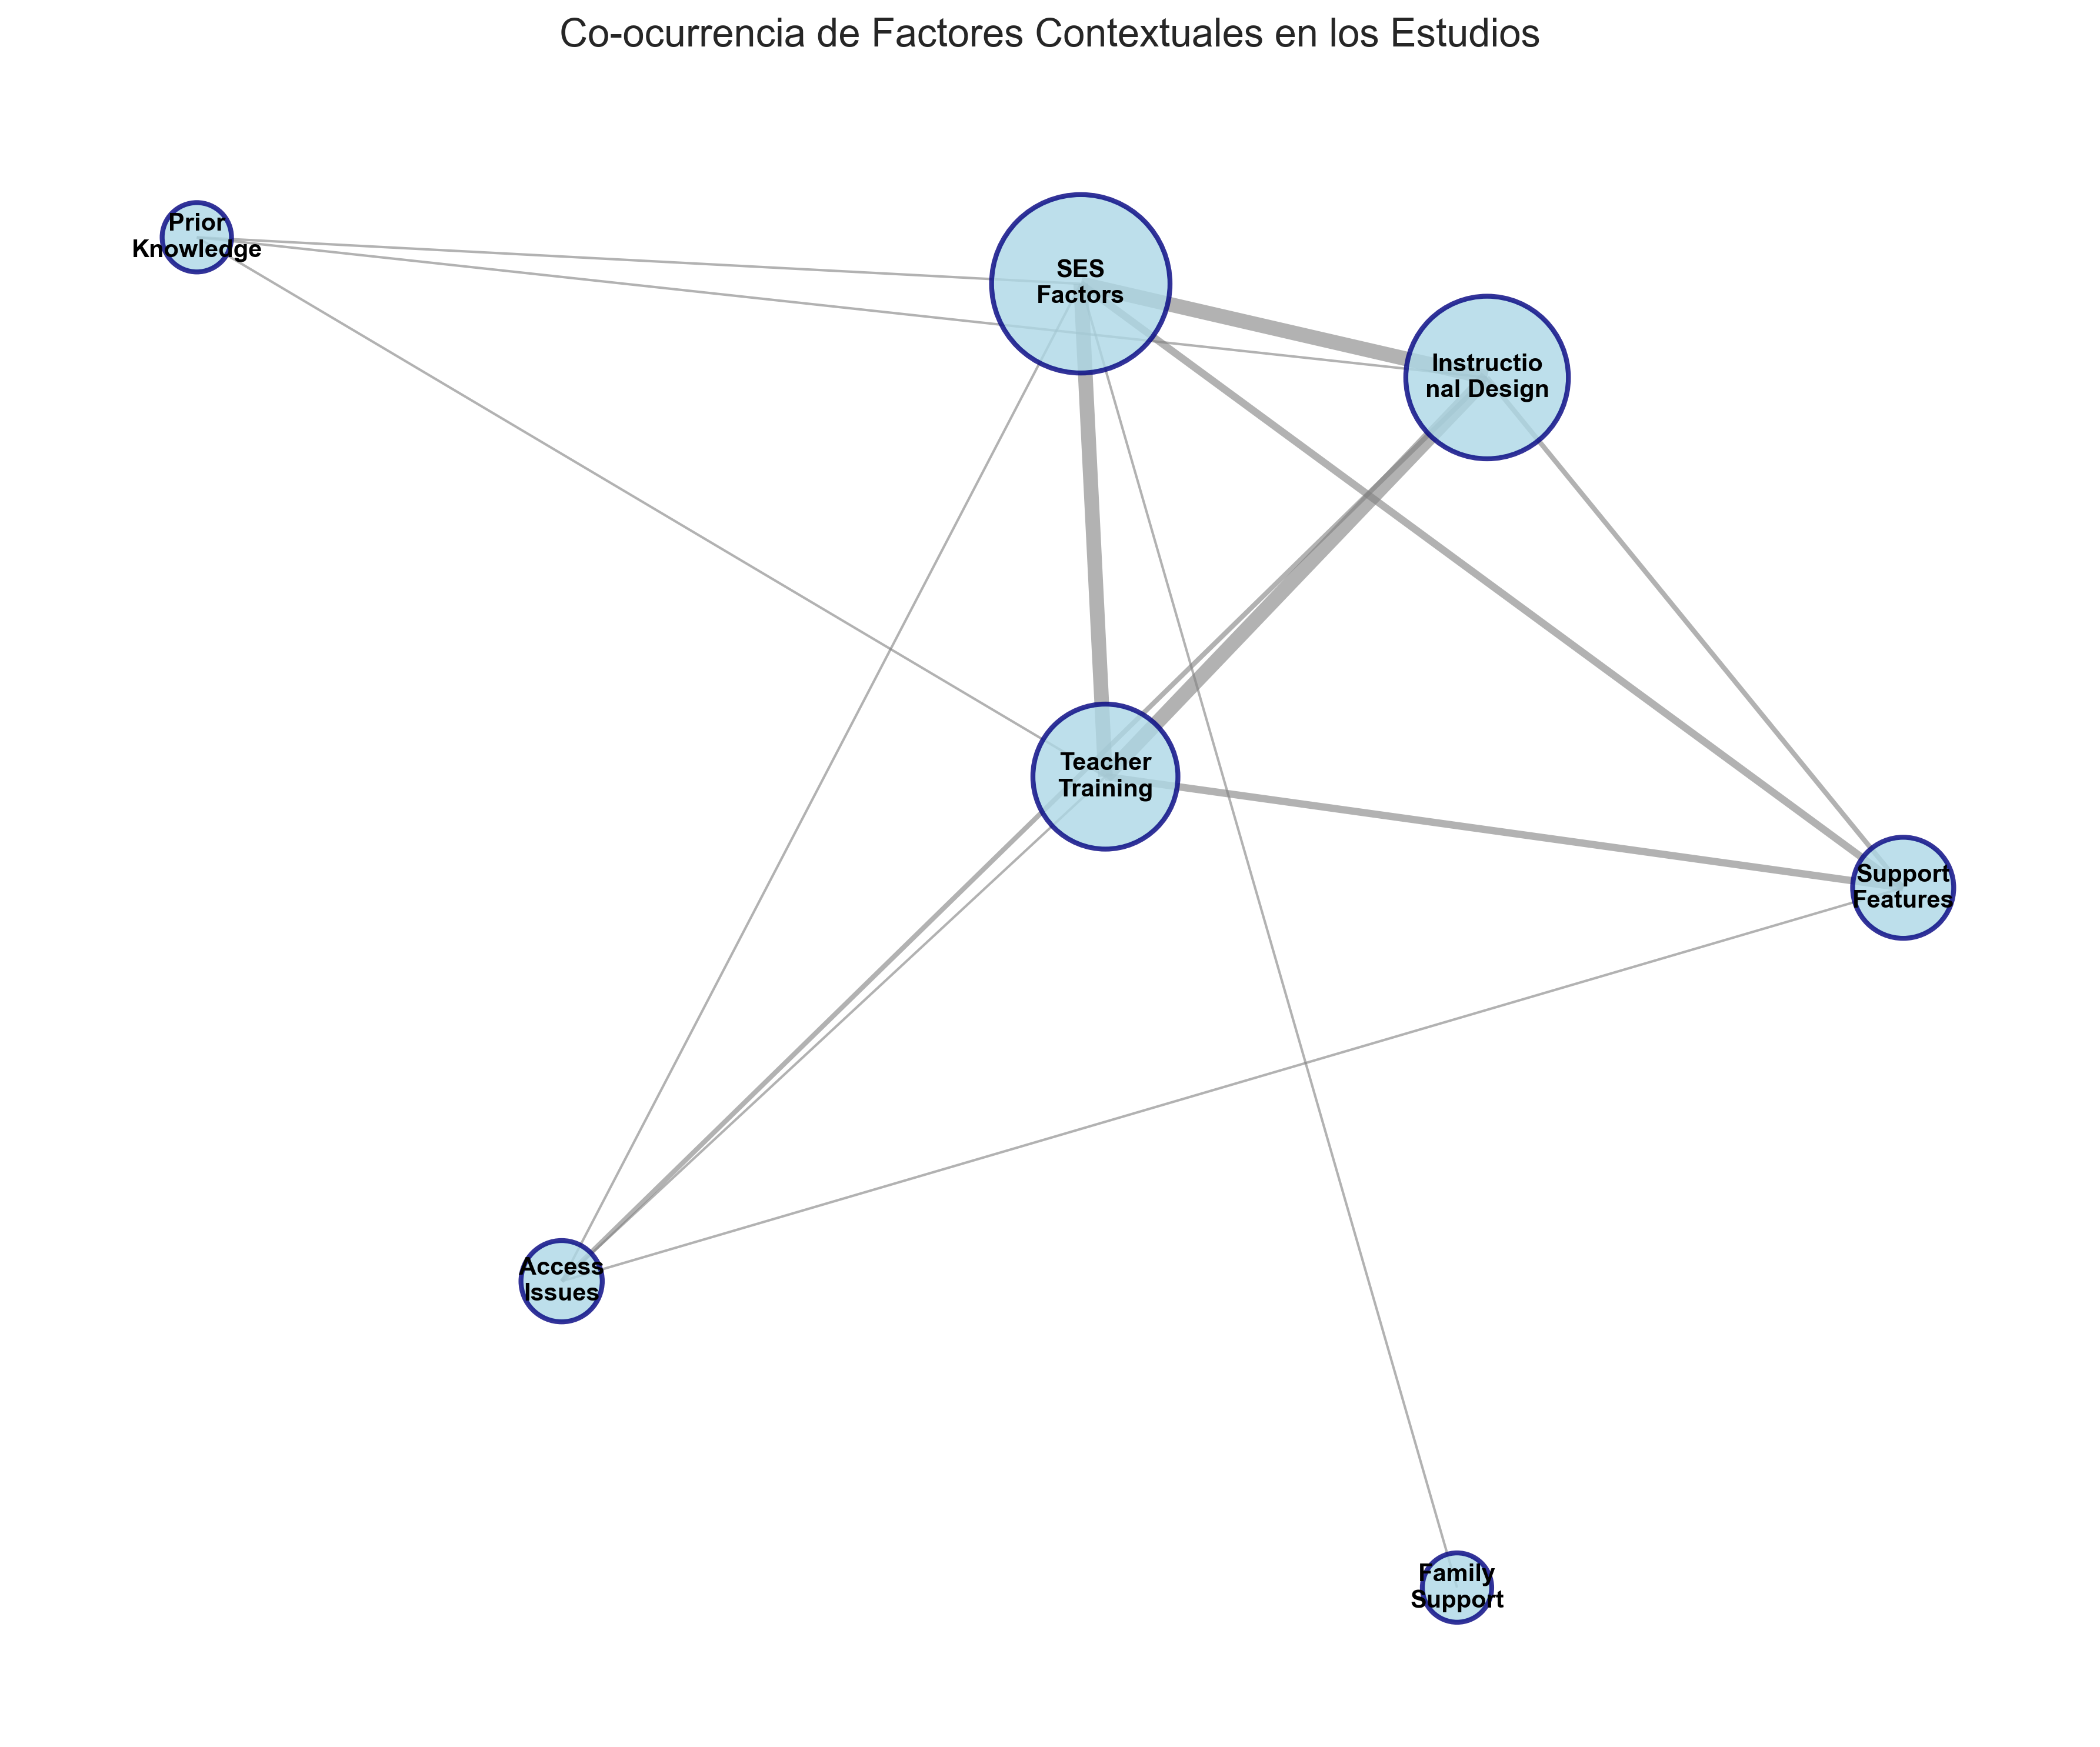

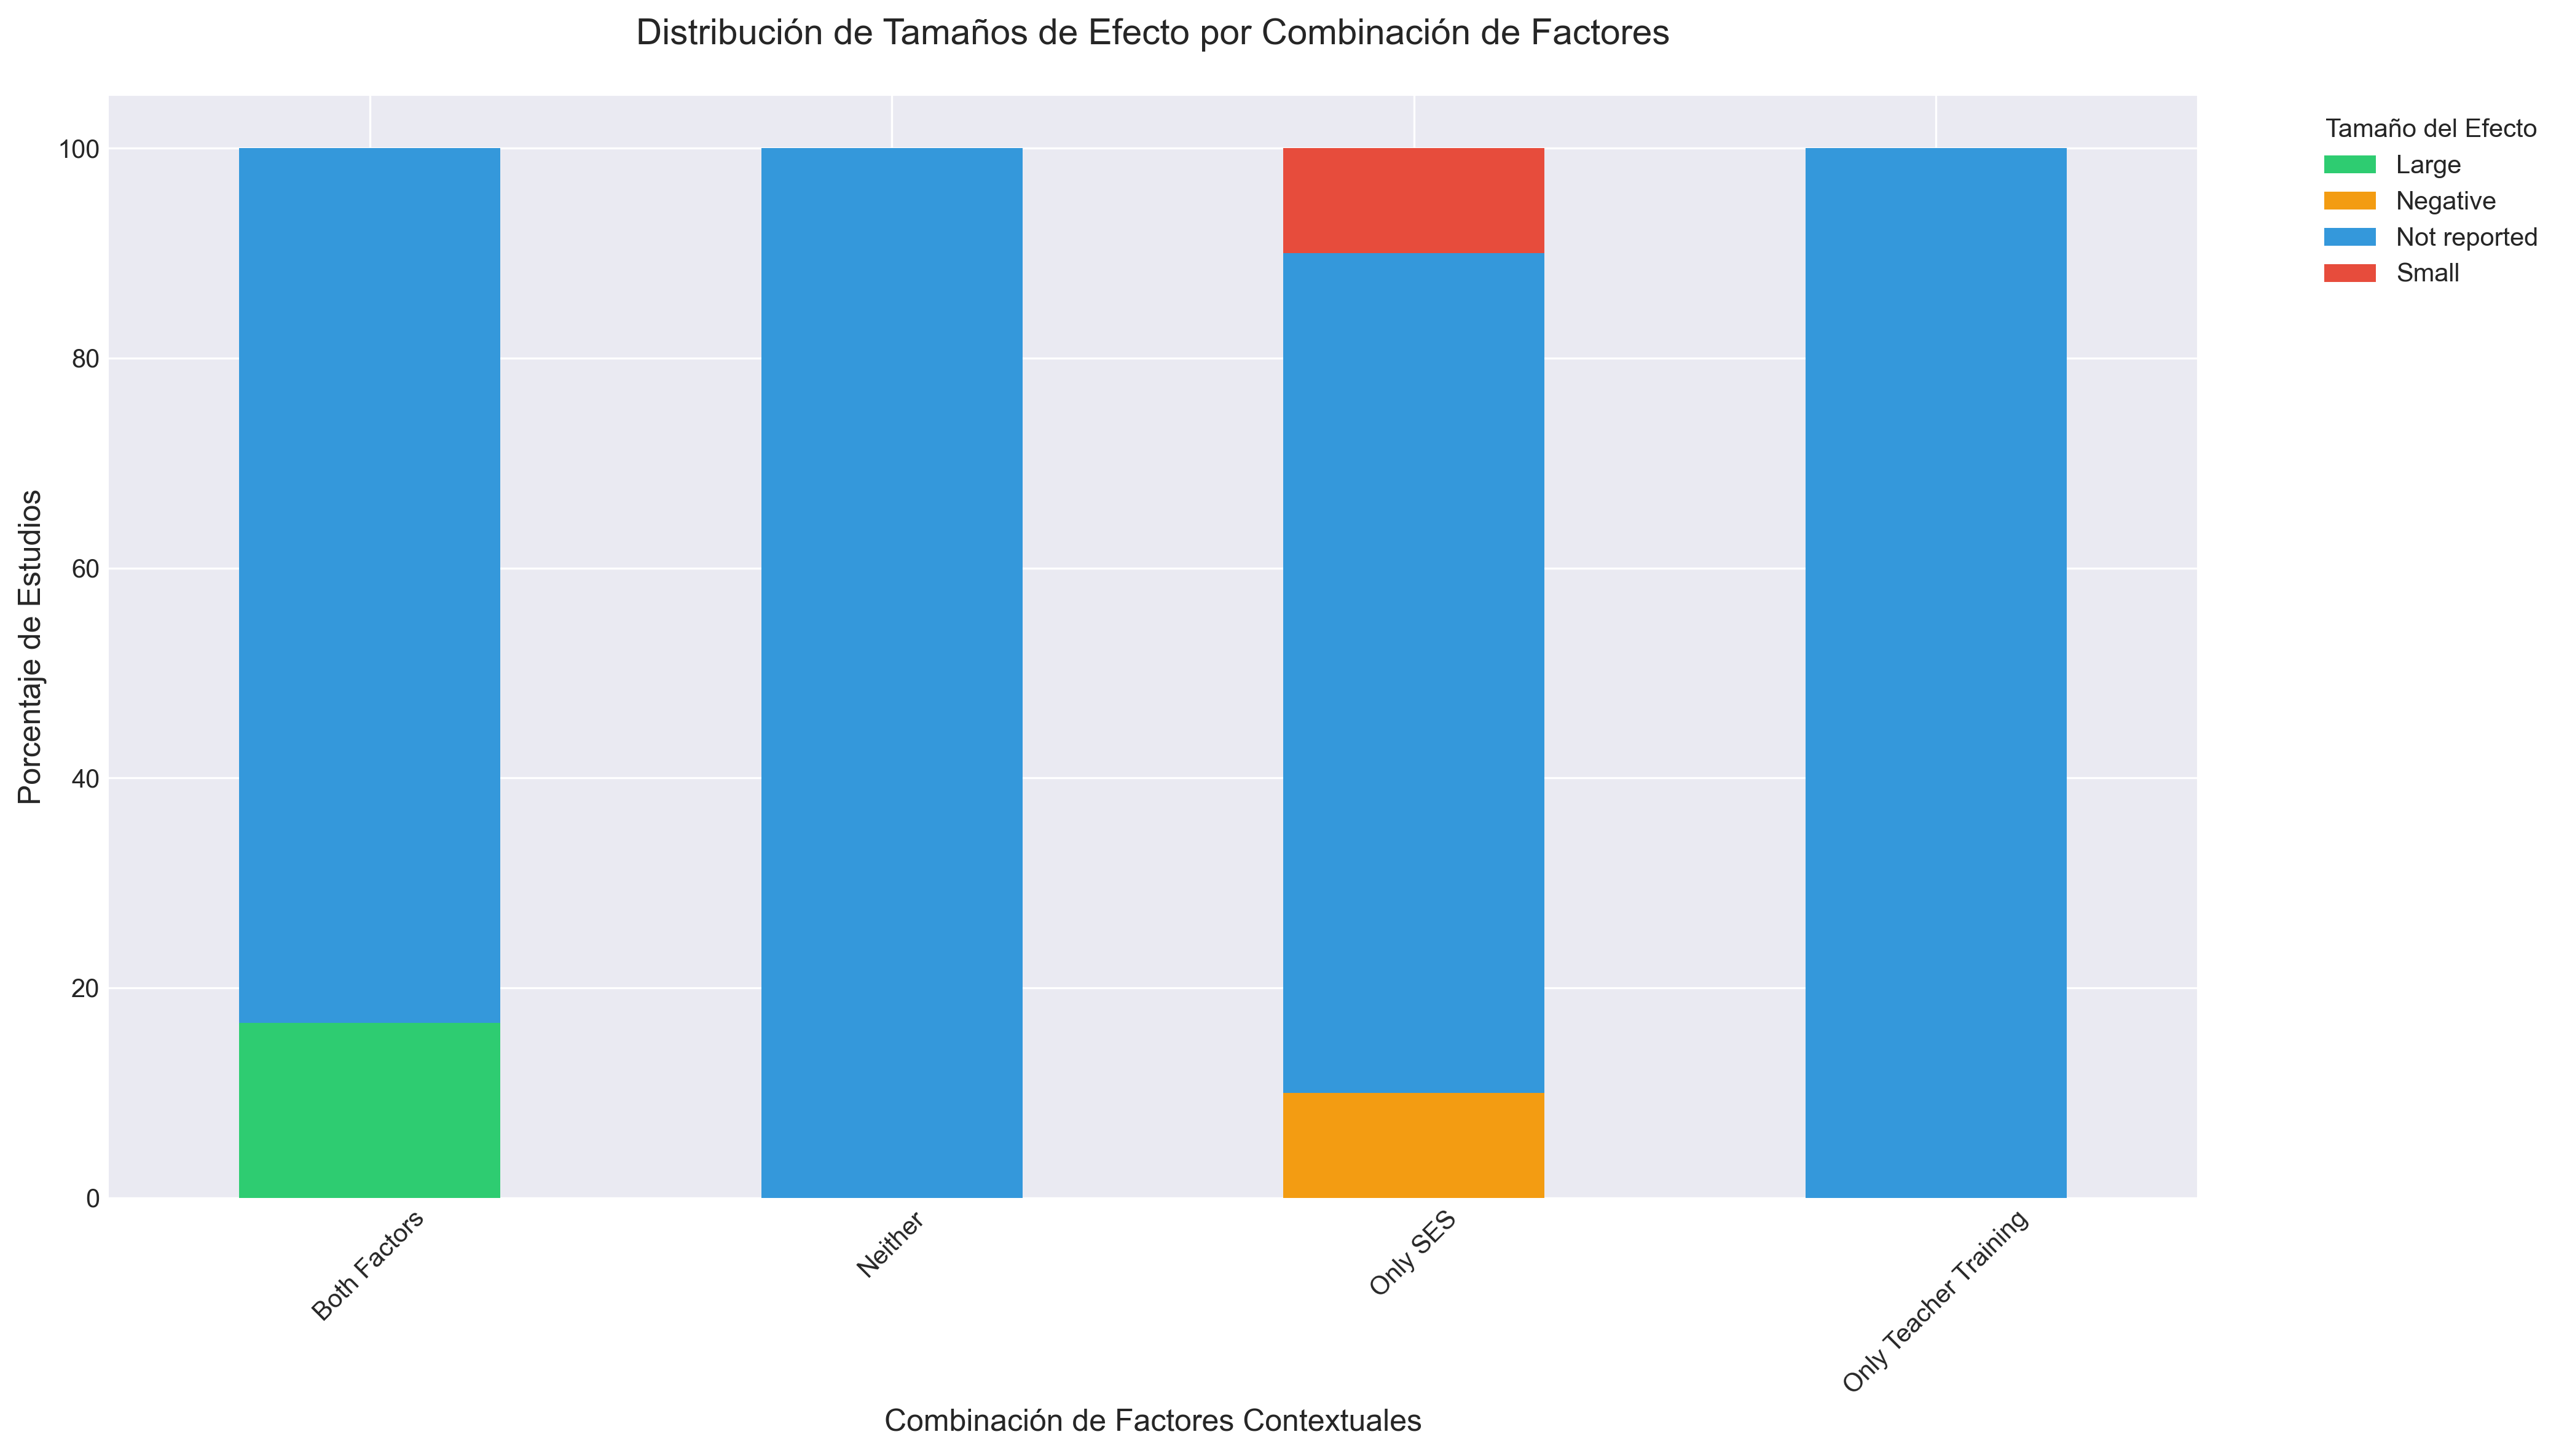

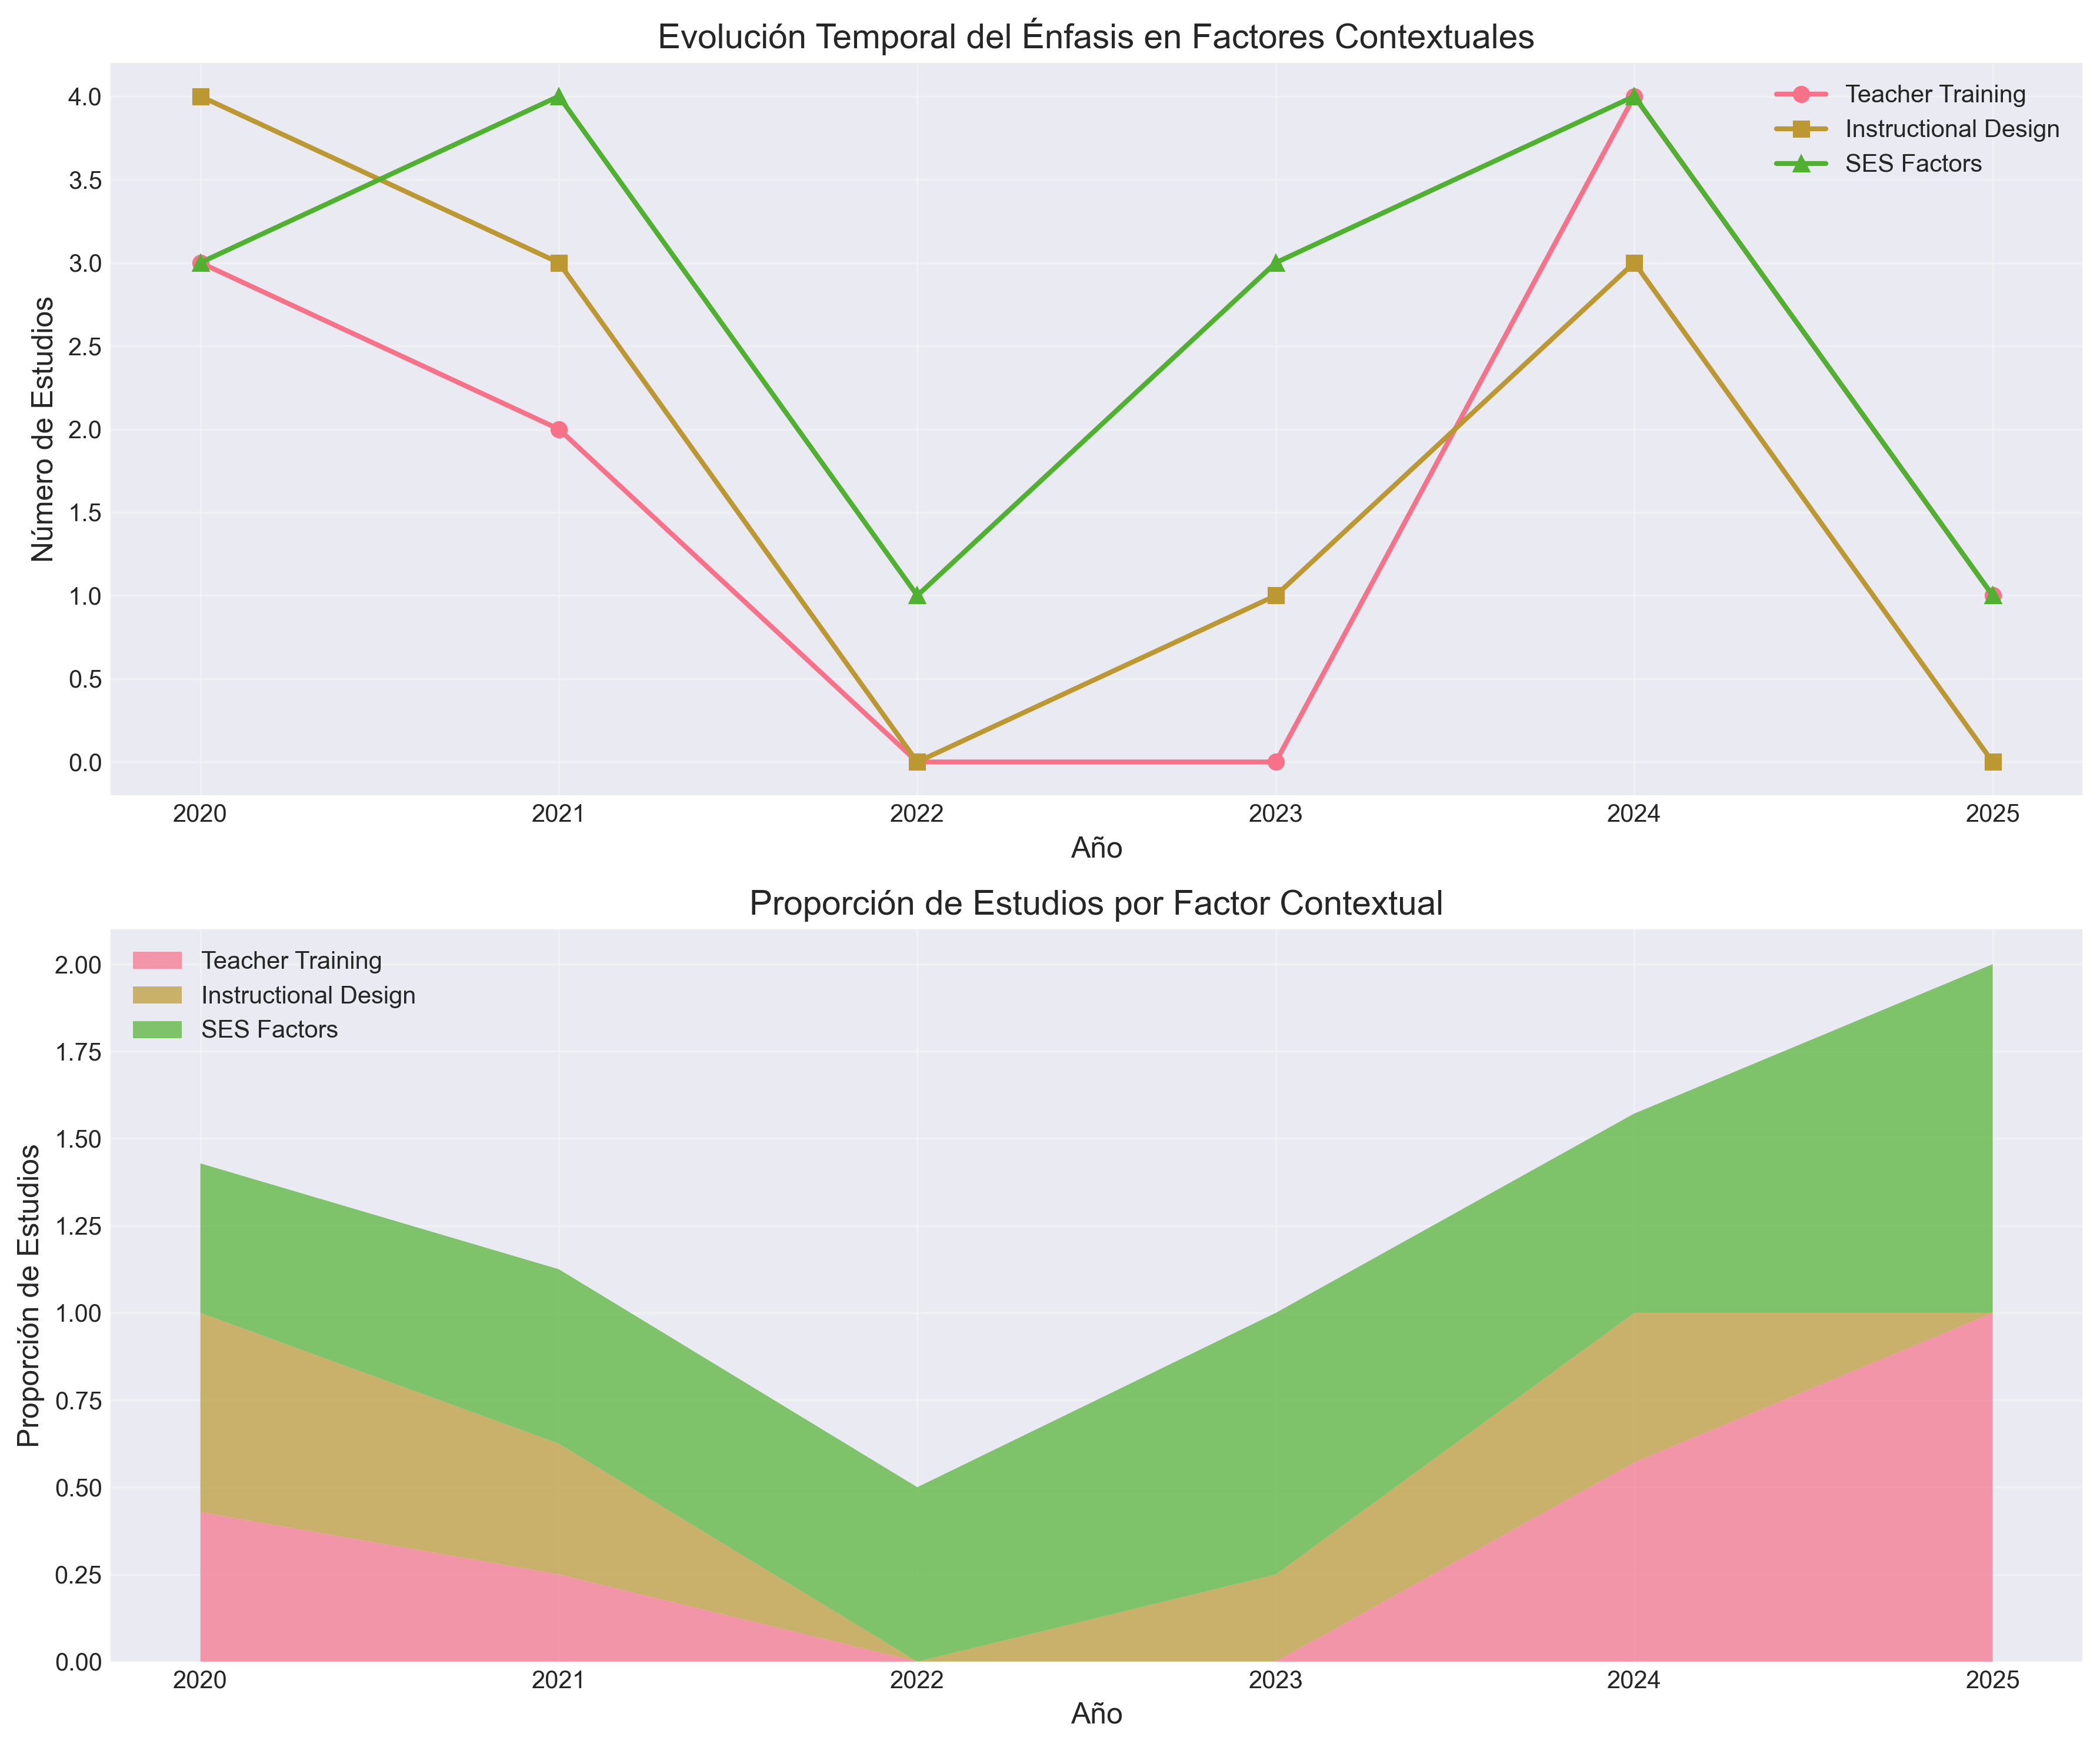

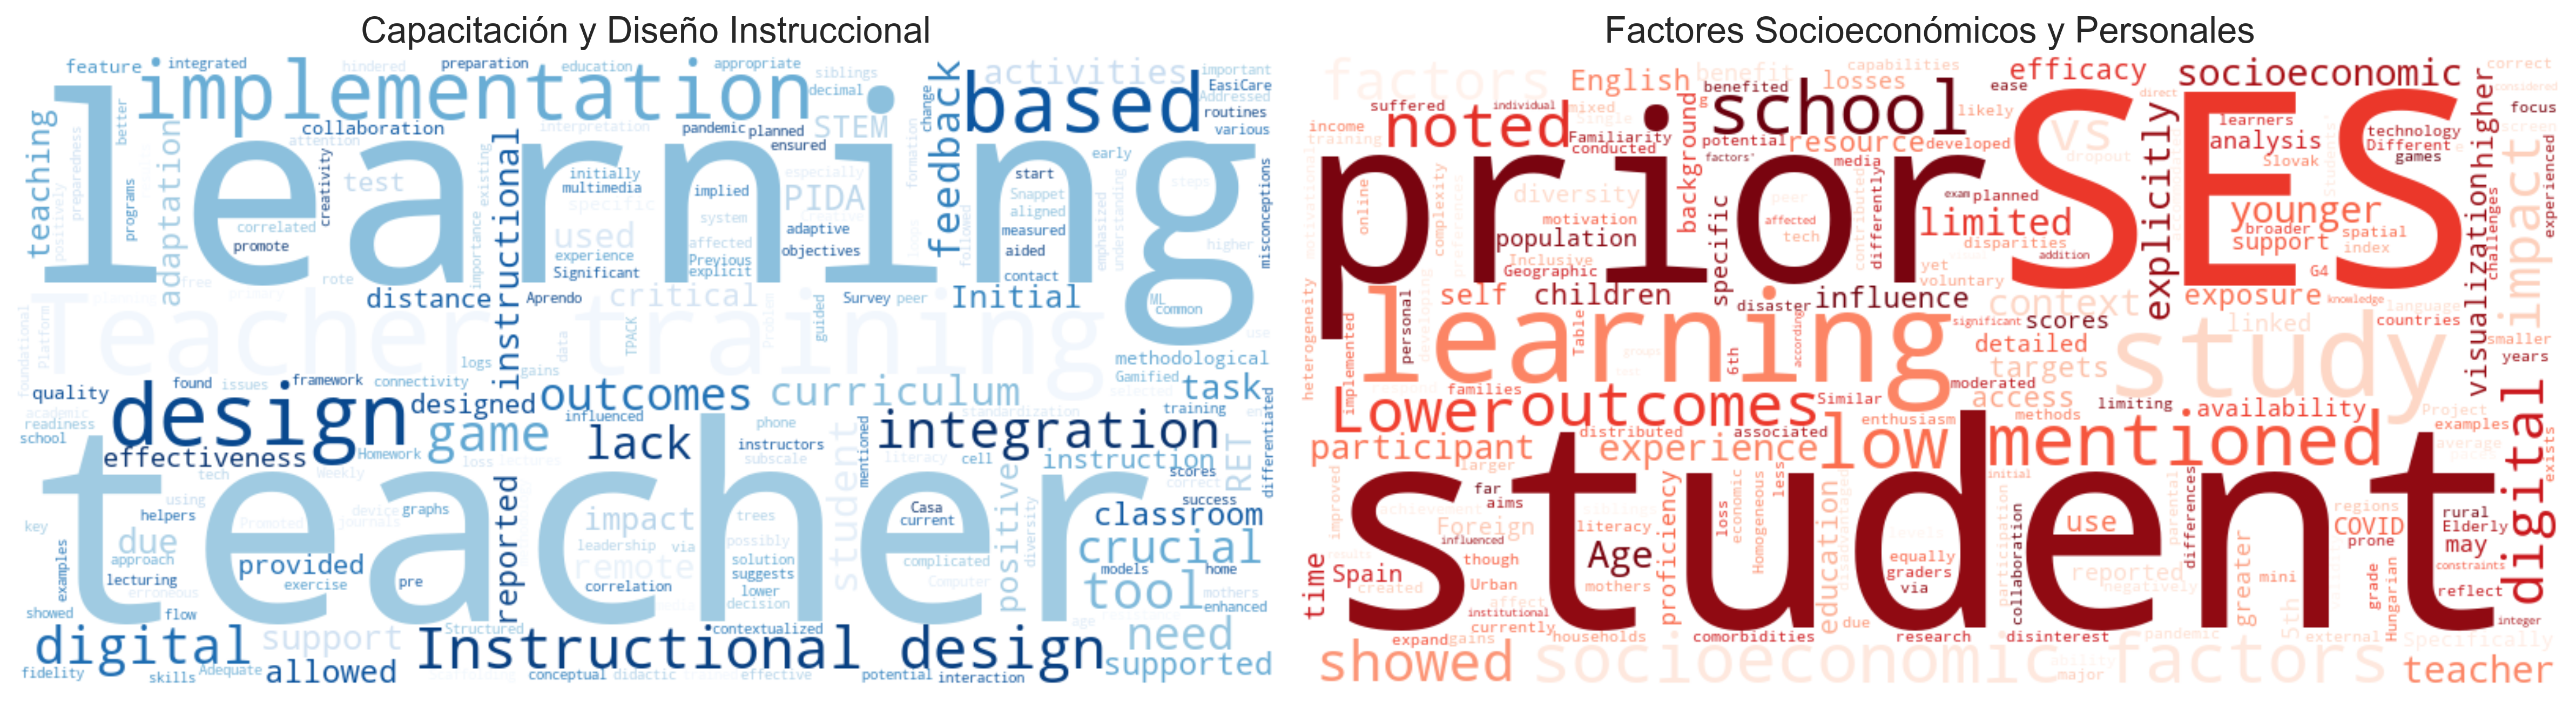

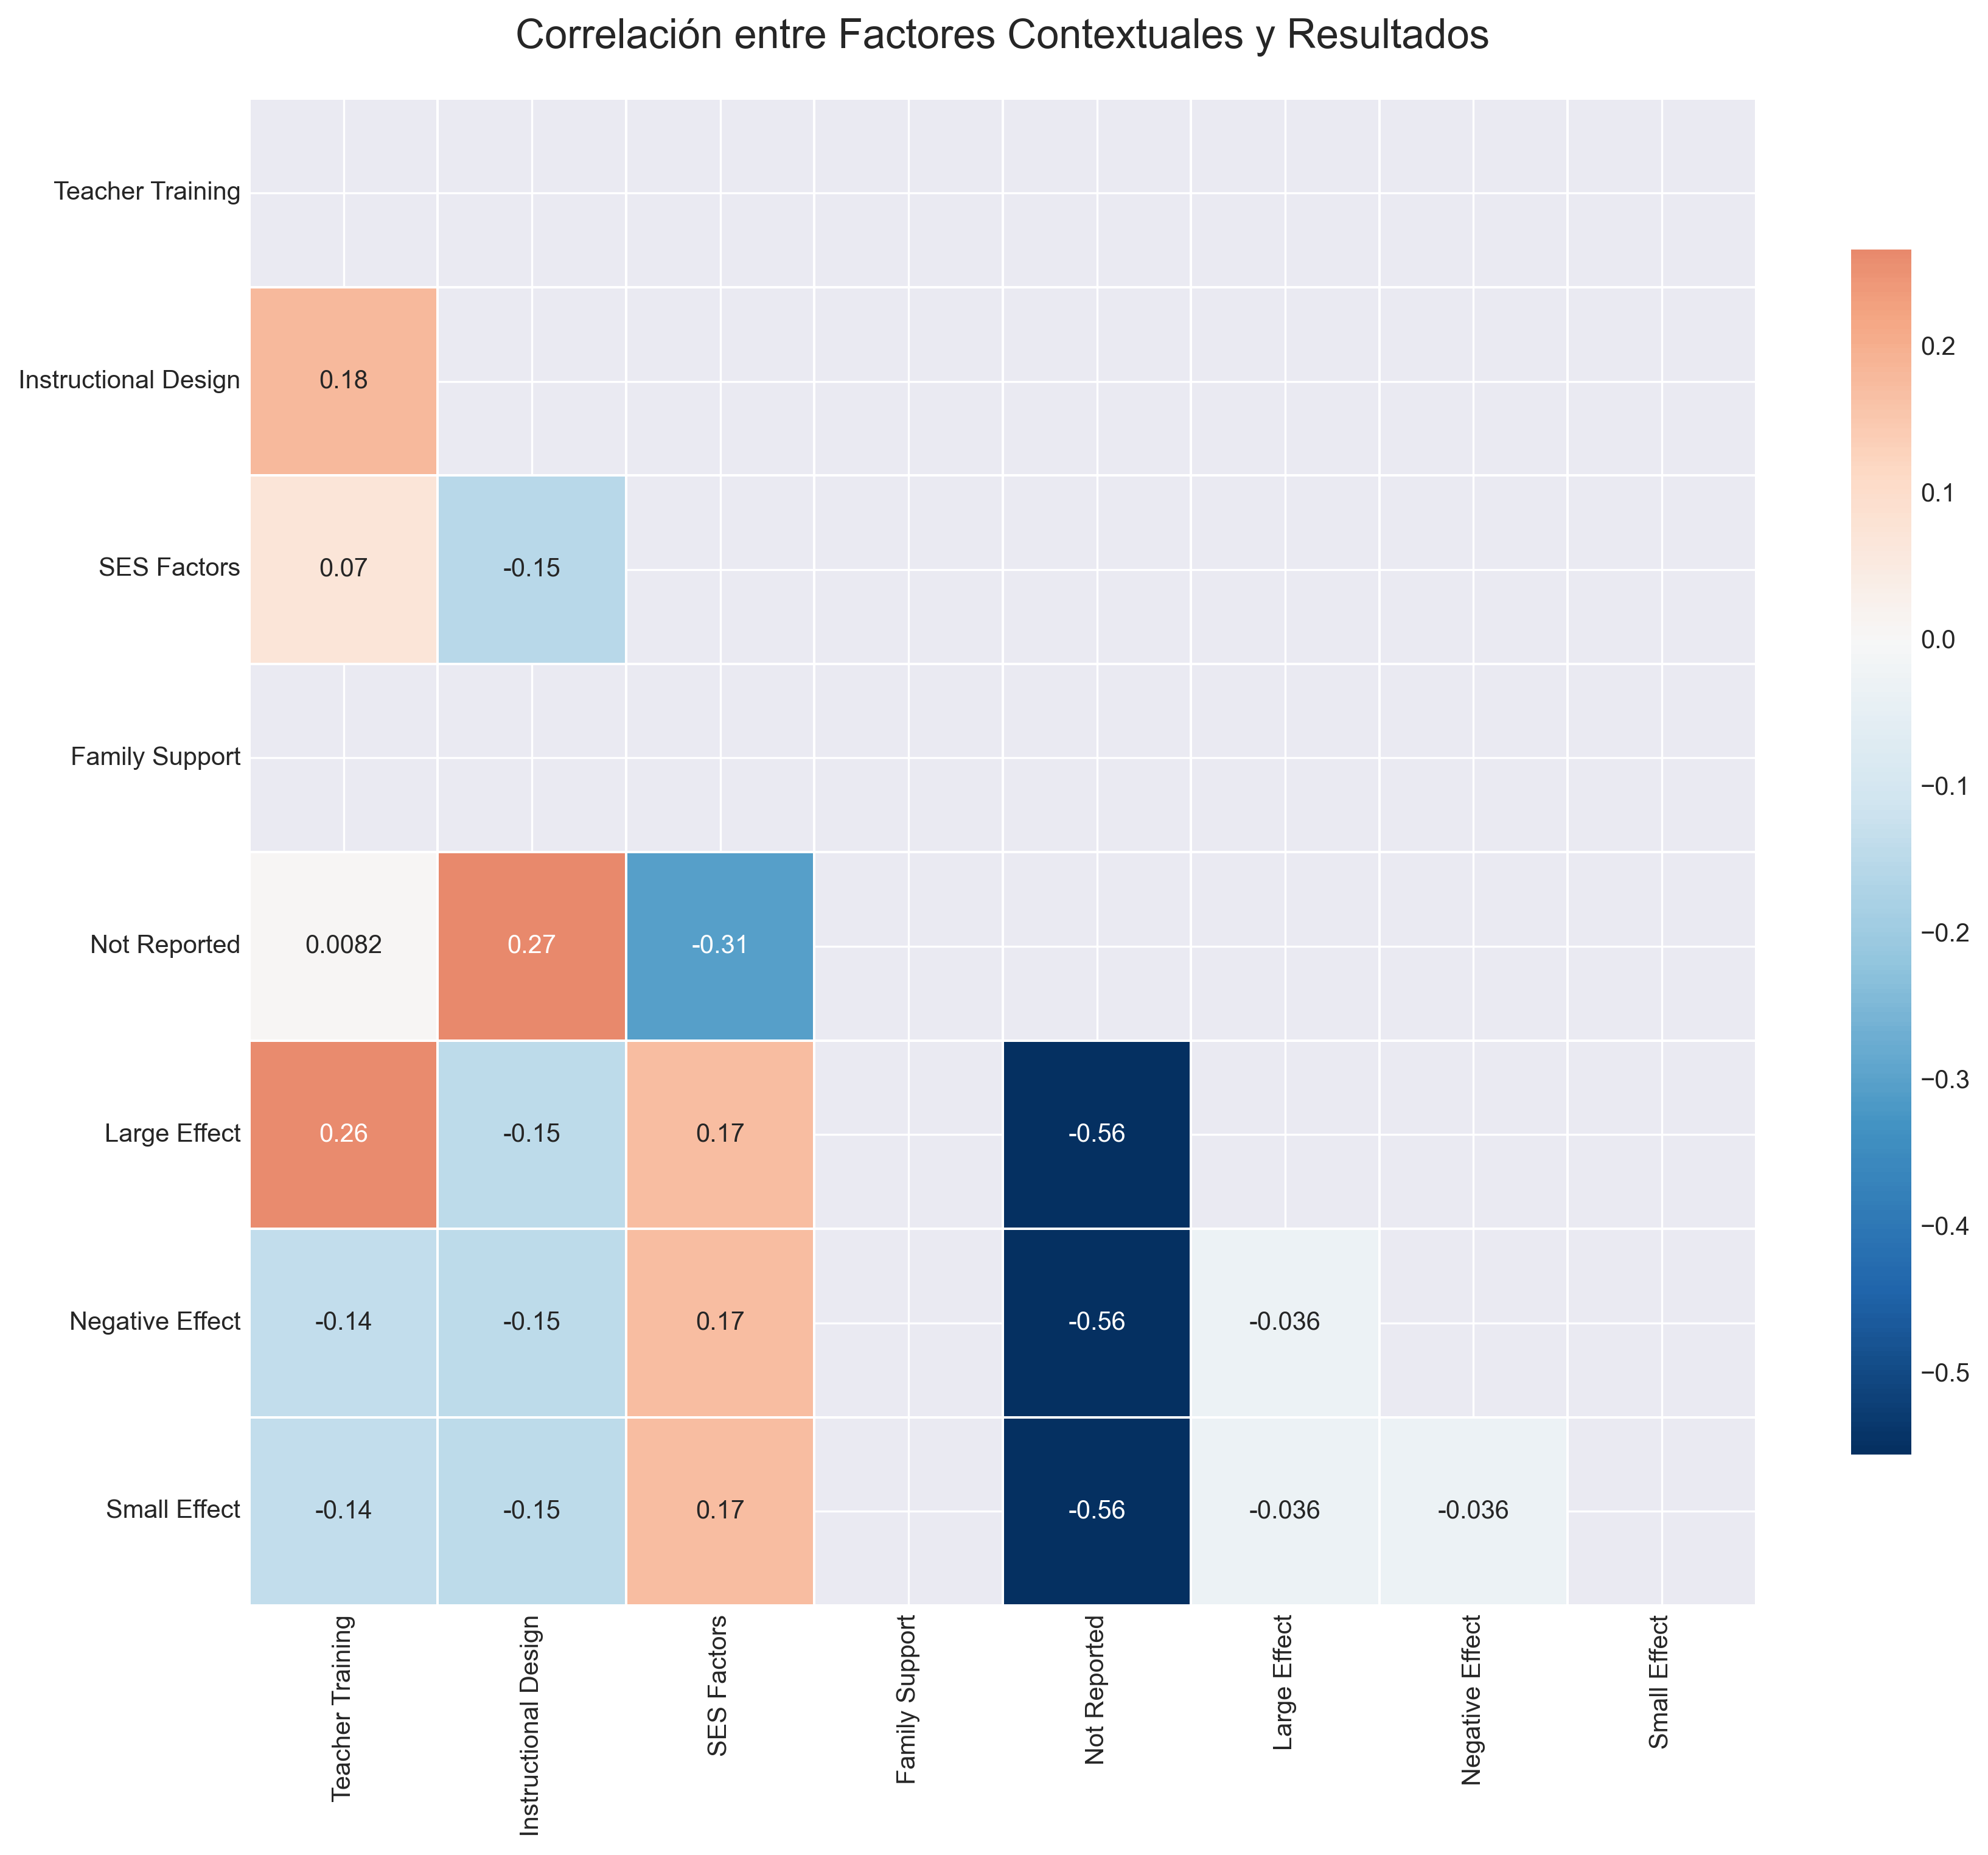

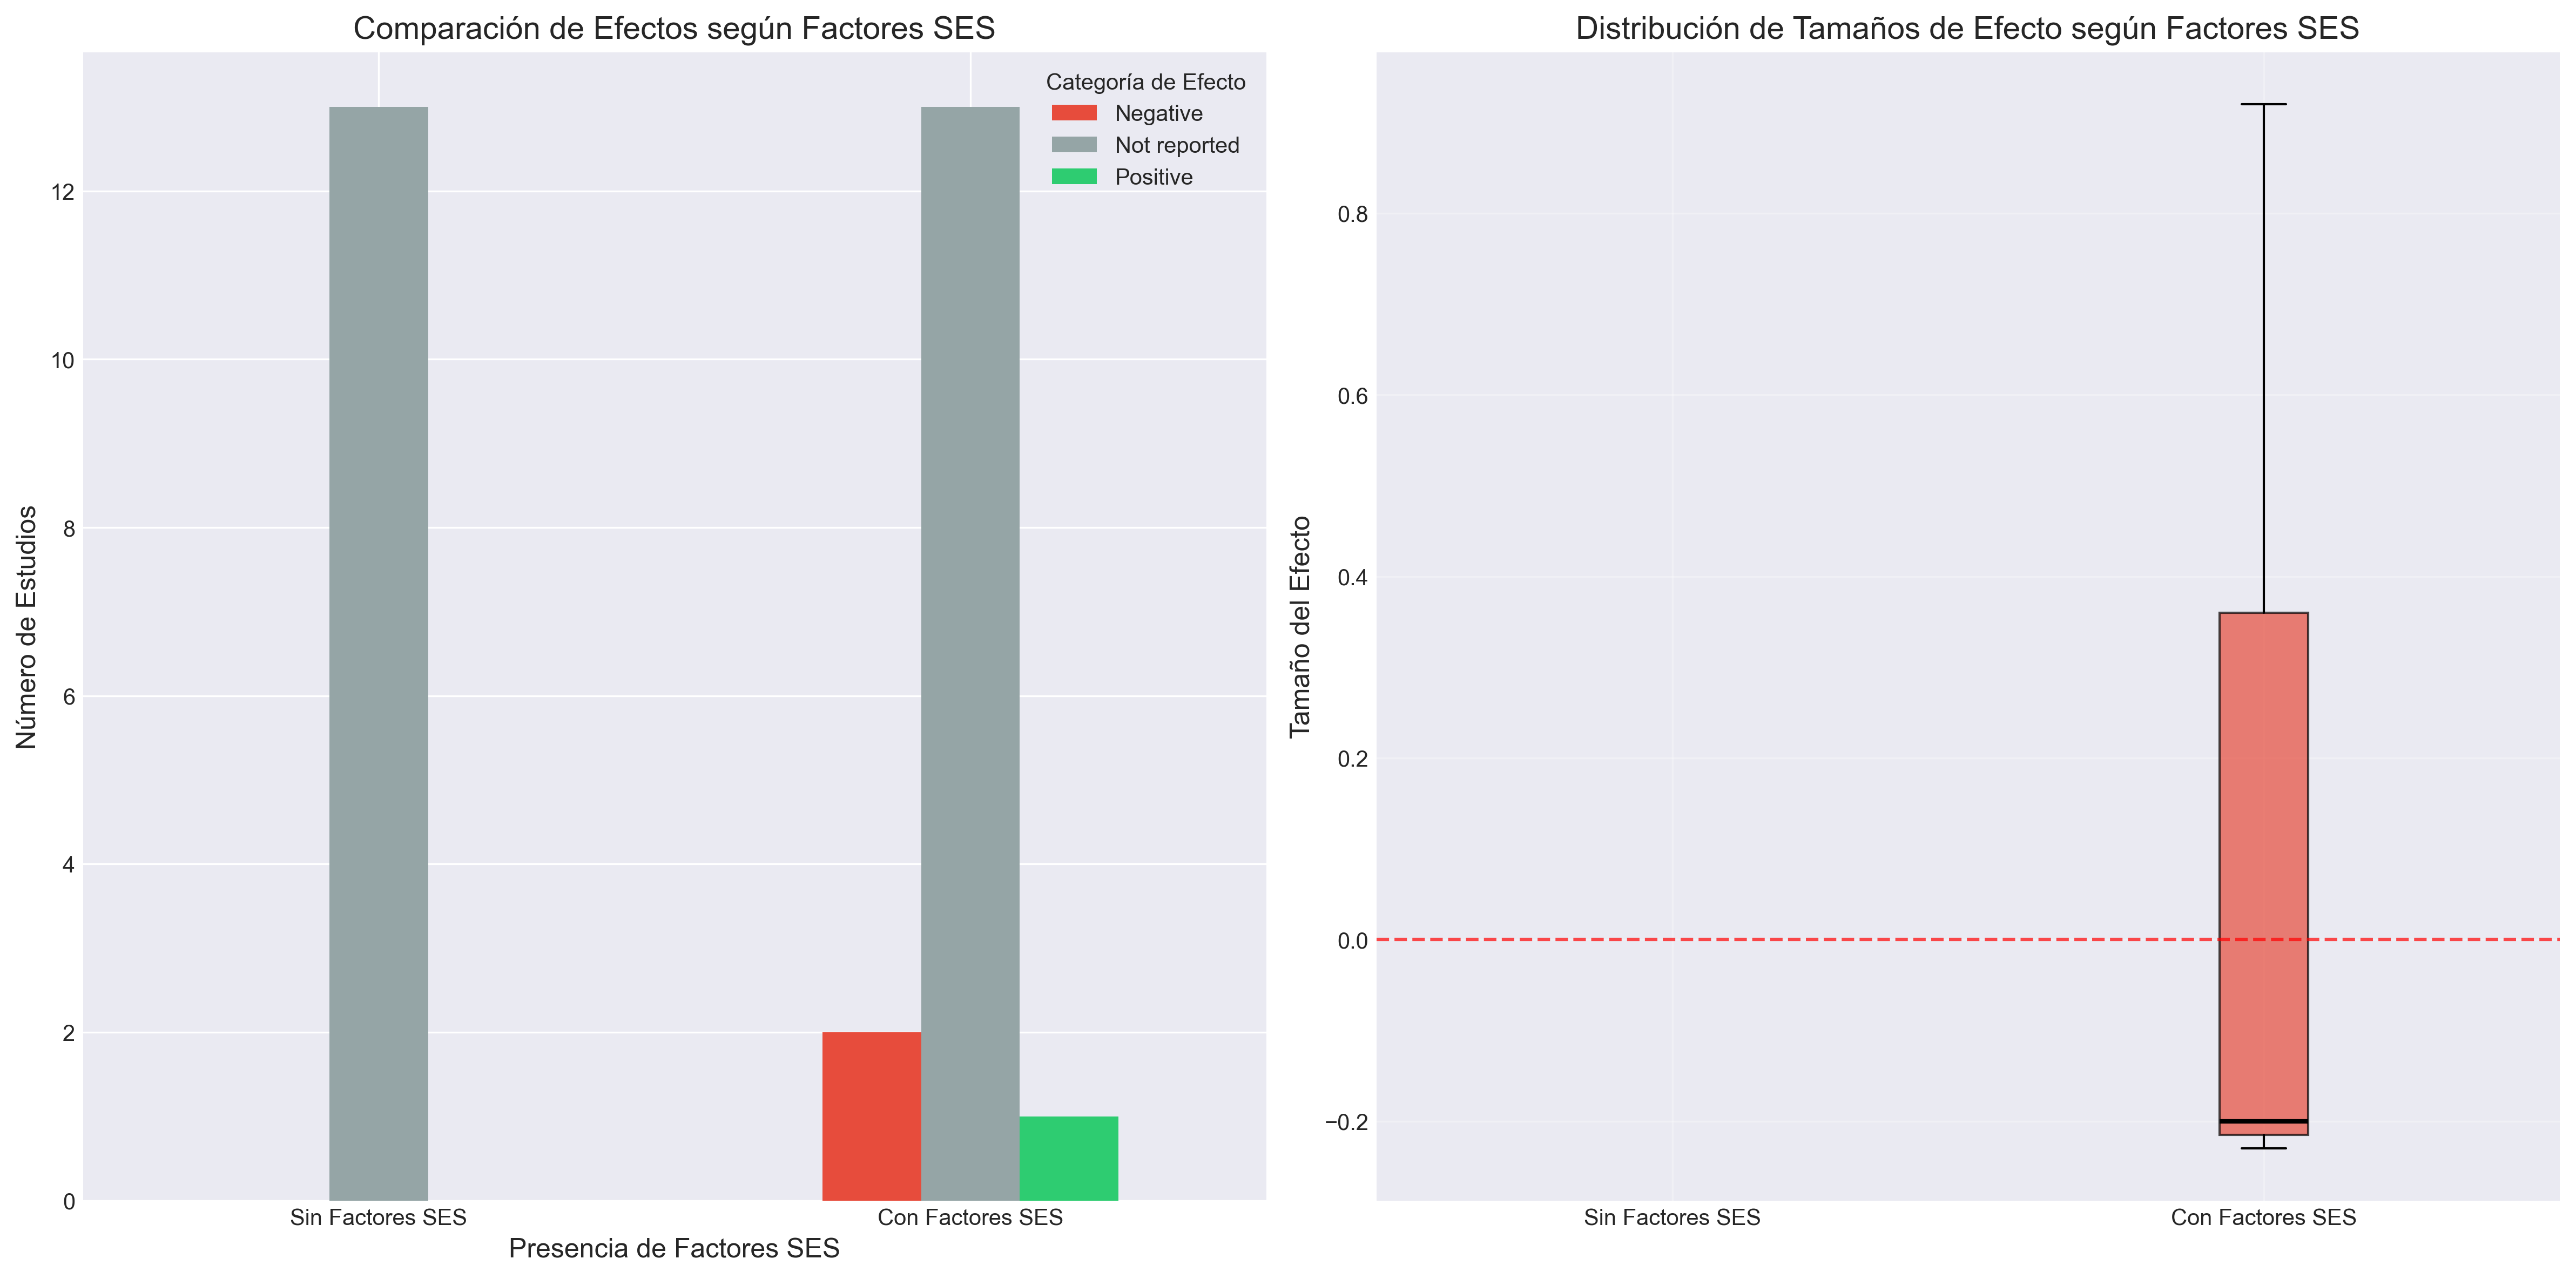

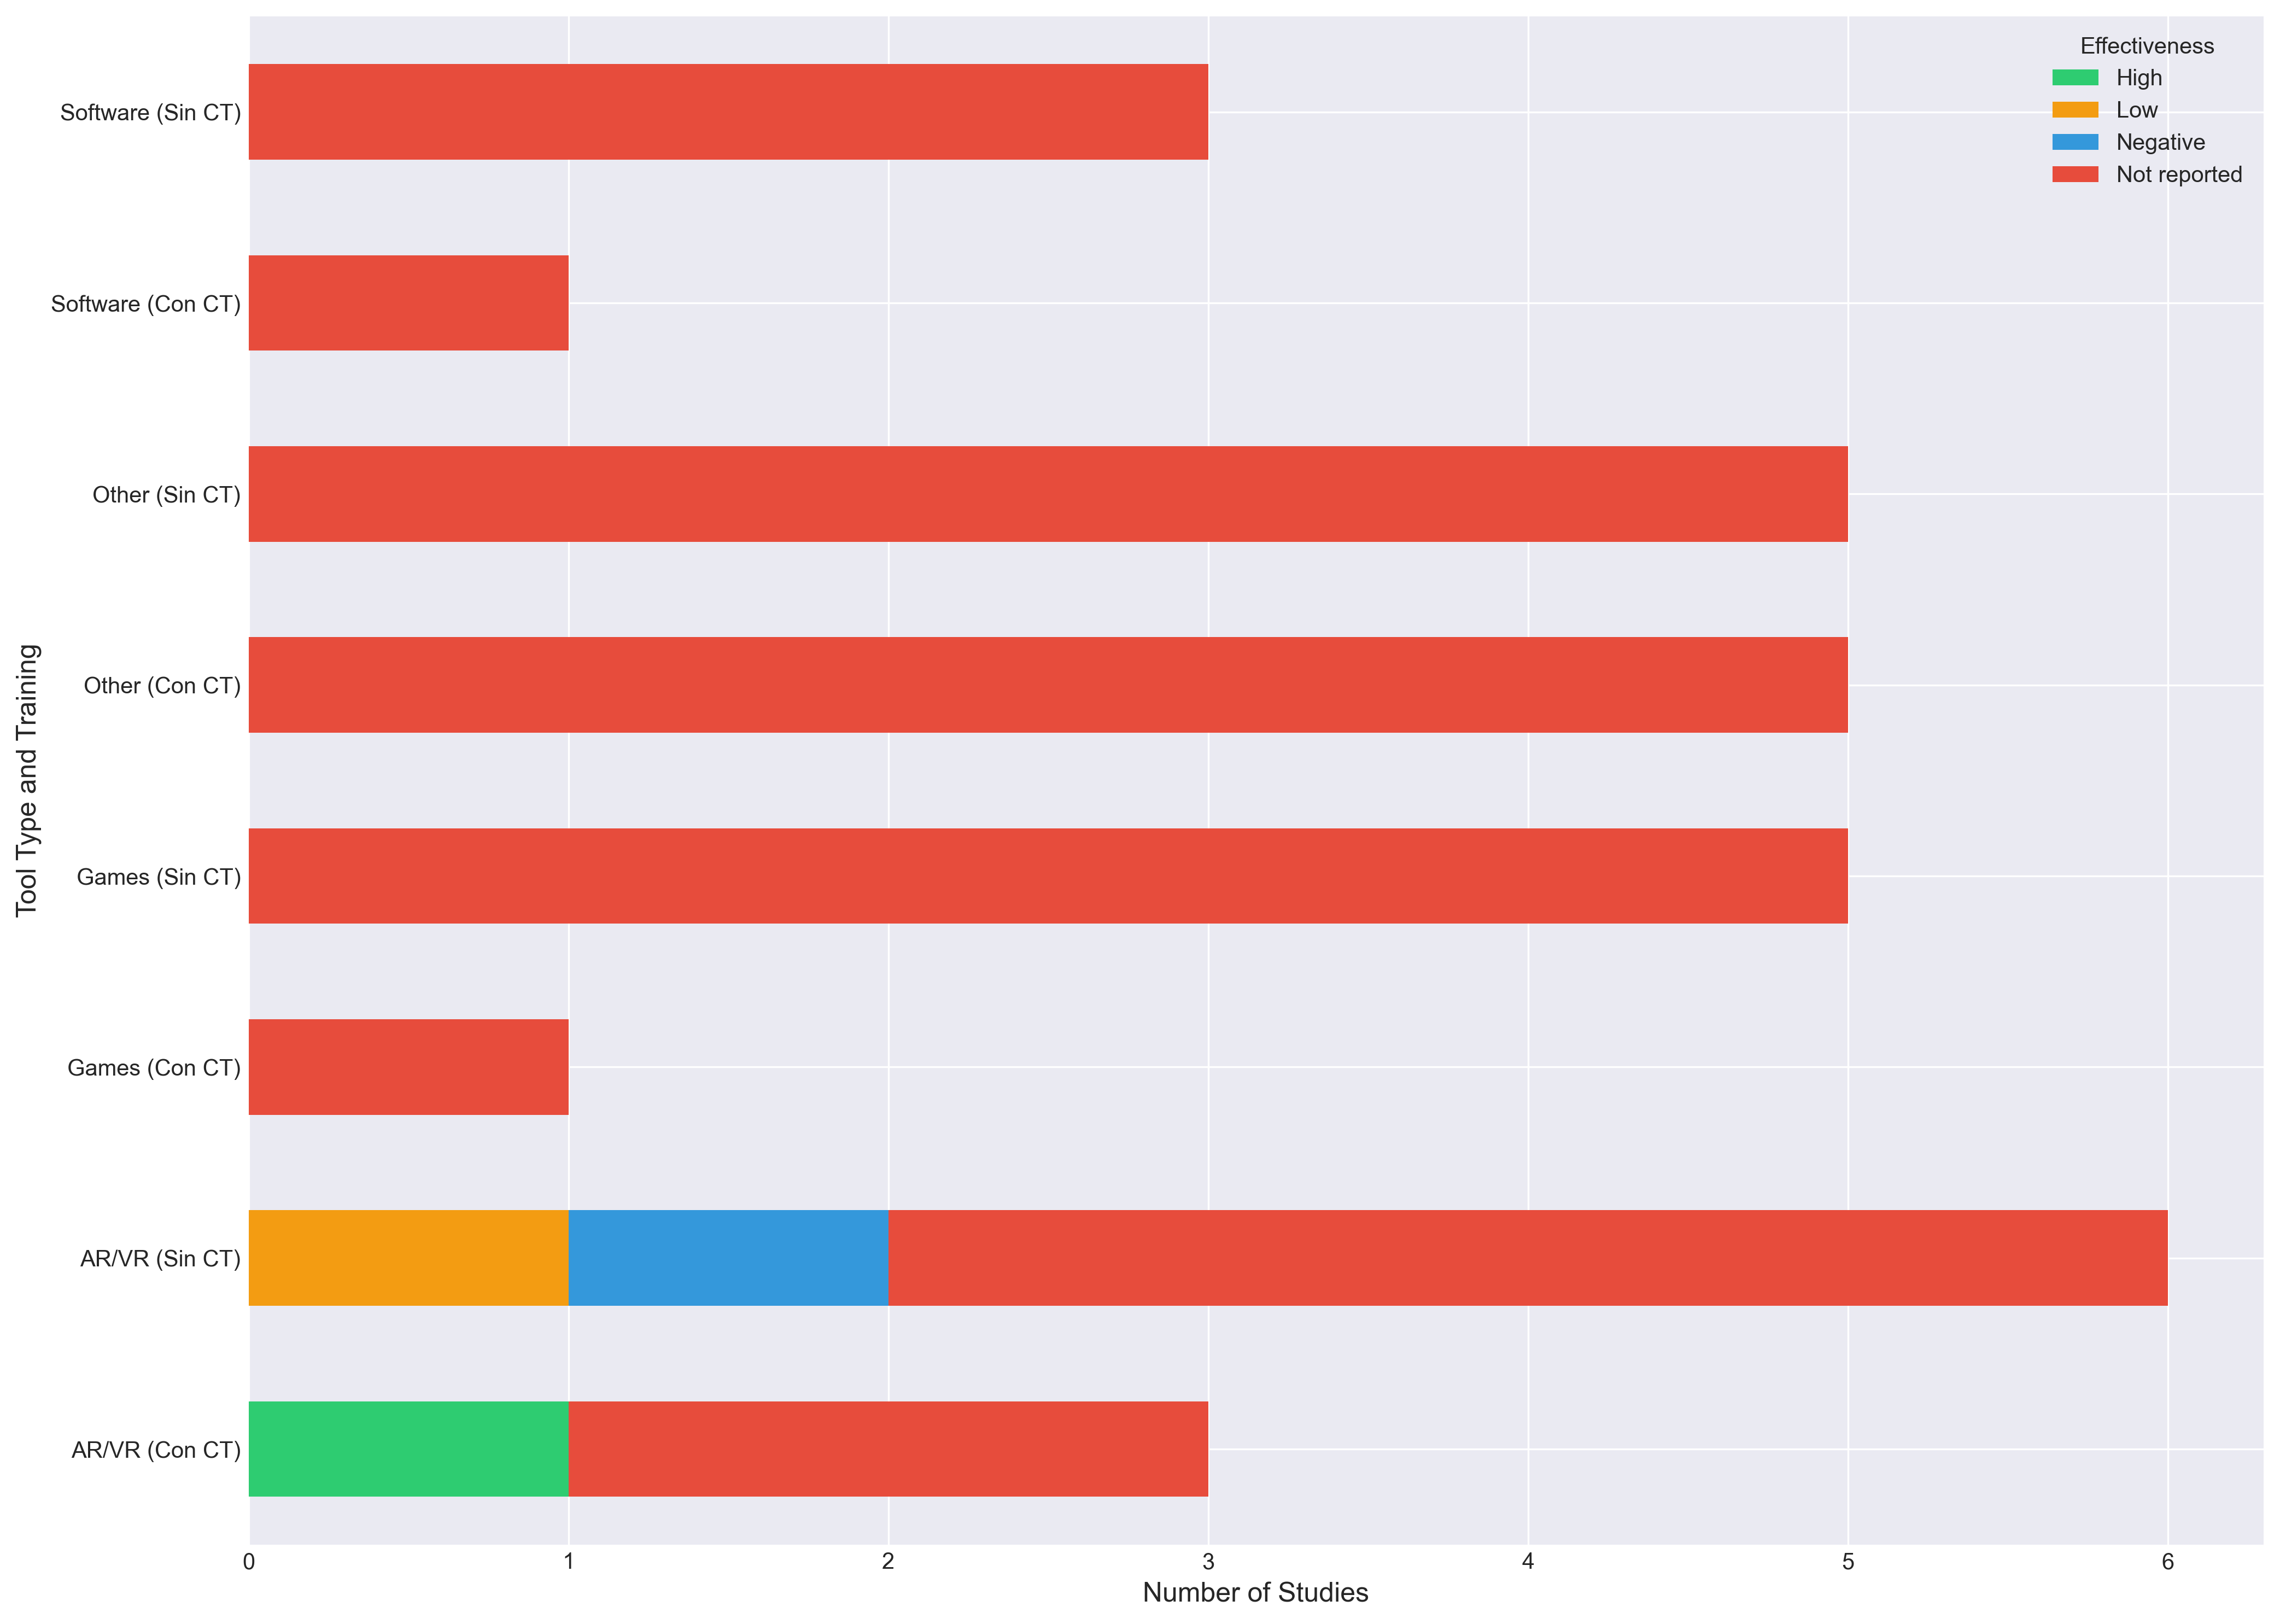

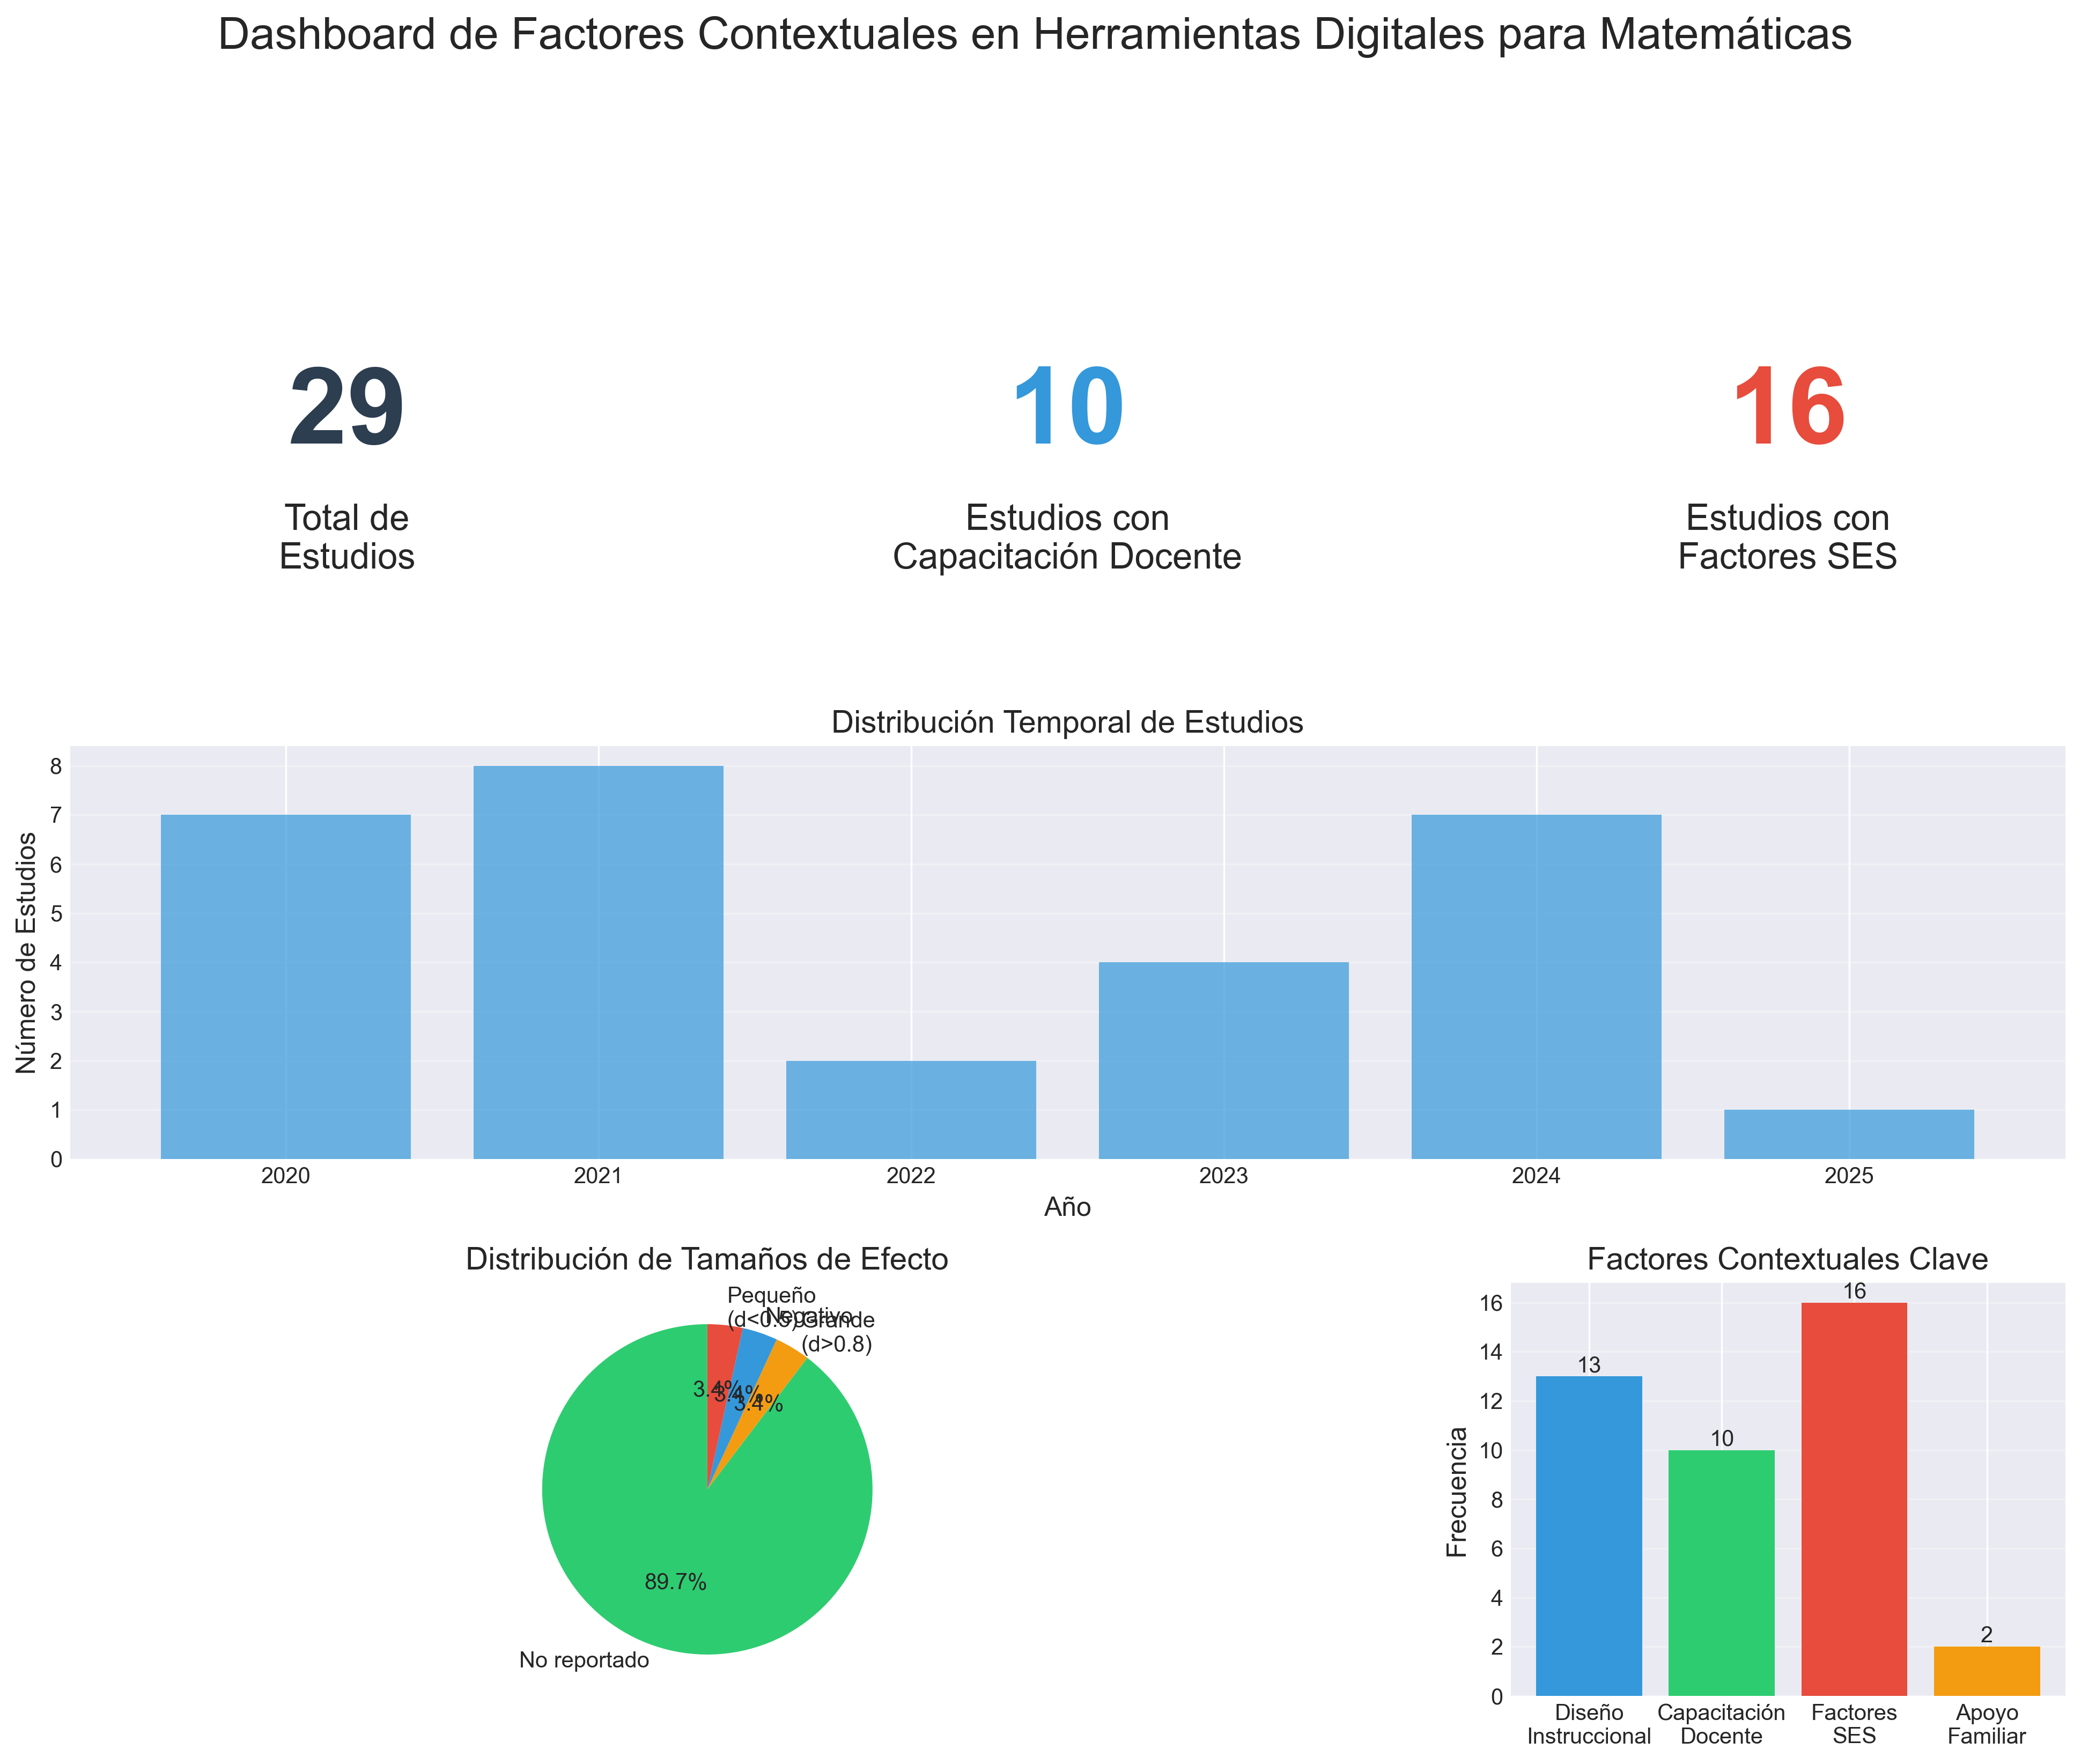

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from matplotlib.patches import Patch
import textwrap

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Leer datos
df = pd.read_csv('analisisTodos.csv', sep=';', encoding='utf-8')

# 1. Análisis de Co-ocurrencia de Factores Contextuales
def create_factor_network():
    """Crea un gráfico de red mostrando la co-ocurrencia de factores contextuales"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Preparar datos para el análisis de co-ocurrencia
    factors = []
    for idx, row in df.iterrows():
        study_factors = []
        
        # Analizar capacitación y diseño instruccional
        cap_text = str(row['Factores Contextuales: Capacitación y Diseño Instruccional'])
        if 'teacher training' in cap_text.lower():
            study_factors.append('Teacher Training')
        if 'design' in cap_text.lower() or 'instructional' in cap_text.lower():
            study_factors.append('Instructional Design')
        if 'scaffolding' in cap_text.lower():
            study_factors.append('Scaffolding')
        if 'support' in cap_text.lower():
            study_factors.append('Support Features')
            
        # Analizar factores socioeconómicos
        soc_text = str(row['Factores Contextuales: Factores Socioeconómicos y Personales'])
        if 'ses' in soc_text.lower() or 'socioeconomic' in soc_text.lower():
            study_factors.append('SES Factors')
        if 'family' in soc_text.lower() or 'parent' in soc_text.lower():
            study_factors.append('Family Support')
        if 'access' in soc_text.lower() or 'connectivity' in soc_text.lower():
            study_factors.append('Access Issues')
        if 'prior knowledge' in soc_text.lower():
            study_factors.append('Prior Knowledge')
            
        factors.append(study_factors)
    
    # Crear matriz de co-ocurrencia
    all_factors = list(set([f for sublist in factors for f in sublist]))
    cooc_matrix = np.zeros((len(all_factors), len(all_factors)))
    
    for study_factors in factors:
        for i, f1 in enumerate(all_factors):
            for j, f2 in enumerate(all_factors):
                if f1 in study_factors and f2 in study_factors and i != j:
                    cooc_matrix[i, j] += 1
    
    # Crear grafo
    G = nx.Graph()
    for i, f1 in enumerate(all_factors):
        for j, f2 in enumerate(all_factors):
            if i < j and cooc_matrix[i, j] > 0:
                G.add_edge(f1, f2, weight=cooc_matrix[i, j])
    
    # Dibujar grafo
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Nodos
    # Nodos
    # Calcular tamaño basado en cuántos estudios mencionan el factor
    # Usamos sum(1 for...) que es eficiente para contar ocurrencias
    node_sizes = [sum(1 for f_list in factors if factor in f_list) * 300 + 500 # Añadir un tamaño base
                for factor in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', 
                          alpha=0.8, edgecolors='navy', linewidths=2)
    
    # Etiquetas
    labels = {node: '\n'.join(textwrap.wrap(node, 10)) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
    
    # Aristas
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6, edge_color='gray')
    
    plt.title('Co-ocurrencia de Factores Contextuales en los Estudios', fontsize=16, pad=20)
    plt.axis('off')
    plt.tight_layout()
    return fig

# 2. Análisis de Efectos por Combinación de Factores
def create_effect_combinations():
    """Analiza los tamaños de efecto según diferentes combinaciones de factores"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Categorizar estudios por combinación de factores
    combinations = []
    for idx, row in df.iterrows():
        has_teacher_training = 'teacher training' in str(row['Factores Contextuales: Capacitación y Diseño Instruccional']).lower()
        has_ses = 'ses' in str(row['Factores Contextuales: Factores Socioeconómicos y Personales']).lower() or \
                  'socioeconomic' in str(row['Factores Contextuales: Factores Socioeconómicos y Personales']).lower()
        
        effect = str(row['Effect Sizes'])
        if 'd=' in effect:
            try:
                d_value = float(effect.split('d=')[1].split()[0].replace(',', '.'))
                effect_category = 'Large' if d_value > 0.8 else 'Medium' if d_value > 0.5 else 'Small'
            except:
                effect_category = 'Not reported'
        elif '-' in effect and 'σ' in effect:
            effect_category = 'Negative'
        else:
            effect_category = 'Not reported'
        
        if has_teacher_training and has_ses:
            combination = 'Both Factors'
        elif has_teacher_training:
            combination = 'Only Teacher Training'
        elif has_ses:
            combination = 'Only SES'
        else:
            combination = 'Neither'
            
        combinations.append({'combination': combination, 'effect': effect_category})
    
    combo_df = pd.DataFrame(combinations)
    
    # Crear gráfico de barras apiladas
    combo_counts = pd.crosstab(combo_df['combination'], combo_df['effect'])
    combo_percentages = combo_counts.div(combo_counts.sum(axis=1), axis=0) * 100
    
    combo_percentages.plot(kind='bar', stacked=True, ax=ax, 
                          color=['#2ecc71', '#f39c12', '#3498db', '#e74c3c', '#95a5a6'])
    
    ax.set_xlabel('Combinación de Factores Contextuales', fontsize=12)
    ax.set_ylabel('Porcentaje de Estudios', fontsize=12)
    ax.set_title('Distribución de Tamaños de Efecto por Combinación de Factores', fontsize=14, pad=20)
    ax.legend(title='Tamaño del Efecto', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig

# 3. Análisis temporal de énfasis en factores contextuales
def create_temporal_emphasis():
    """Muestra la evolución del énfasis en diferentes factores contextuales"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Agrupar por año
    df['Year'] = df['Year'].astype(int)
    yearly_factors = []
    
    for year in sorted(df['Year'].unique()):
        year_data = df[df['Year'] == year]
        
        # Contar menciones de factores
        teacher_training = sum('teacher training' in str(row['Factores Contextuales: Capacitación y Diseño Instruccional']).lower() 
                              for _, row in year_data.iterrows())
        design = sum('design' in str(row['Factores Contextuales: Capacitación y Diseño Instruccional']).lower() 
                    for _, row in year_data.iterrows())
        ses = sum('ses' in str(row['Factores Contextuales: Factores Socioeconómicos y Personales']).lower() or 
                  'socioeconomic' in str(row['Factores Contextuales: Factores Socioeconómicos y Personales']).lower()
                  for _, row in year_data.iterrows())
        
        yearly_factors.append({
            'Year': year,
            'Teacher Training': teacher_training,
            'Instructional Design': design,
            'SES Factors': ses,
            'Total Studies': len(year_data)
        })
    
    time_df = pd.DataFrame(yearly_factors)
    
    # Gráfico 1: Líneas de tendencia
    ax1.plot(time_df['Year'], time_df['Teacher Training'], marker='o', label='Teacher Training', linewidth=2)
    ax1.plot(time_df['Year'], time_df['Instructional Design'], marker='s', label='Instructional Design', linewidth=2)
    ax1.plot(time_df['Year'], time_df['SES Factors'], marker='^', label='SES Factors', linewidth=2)
    
    ax1.set_xlabel('Año', fontsize=12)
    ax1.set_ylabel('Número de Estudios', fontsize=12)
    ax1.set_title('Evolución Temporal del Énfasis en Factores Contextuales', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Áreas apiladas (proporciones)
    factors_prop = time_df[['Teacher Training', 'Instructional Design', 'SES Factors']].div(time_df['Total Studies'], axis=0)
    ax2.stackplot(time_df['Year'], factors_prop.T, labels=['Teacher Training', 'Instructional Design', 'SES Factors'],
                  alpha=0.7)
    
    ax2.set_xlabel('Año', fontsize=12)
    ax2.set_ylabel('Proporción de Estudios', fontsize=12)
    ax2.set_title('Proporción de Estudios por Factor Contextual', fontsize=14)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# 4. Nube de palabras de factores contextuales
def create_contextual_wordcloud():
    """Crea nubes de palabras para los factores contextuales"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Recopilar texto
    capacitacion_text = ' '.join(df['Factores Contextuales: Capacitación y Diseño Instruccional'].astype(str))
    socioeconomic_text = ' '.join(df['Factores Contextuales: Factores Socioeconómicos y Personales'].astype(str))
    
    # Crear wordclouds
    wc1 = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(capacitacion_text)
    wc2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(socioeconomic_text)
    
    ax1.imshow(wc1, interpolation='bilinear')
    ax1.set_title('Capacitación y Diseño Instruccional', fontsize=16)
    ax1.axis('off')
    
    ax2.imshow(wc2, interpolation='bilinear')
    ax2.set_title('Factores Socioeconómicos y Personales', fontsize=16)
    ax2.axis('off')
    
    plt.tight_layout()
    return fig

# 5. Análisis de correlación entre factores y resultados
def create_correlation_matrix():
    """Crea una matriz de correlación entre factores contextuales y resultados"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Crear variables binarias para factores y resultados
    analysis_df = pd.DataFrame()
    
    # Factores contextuales
    analysis_df['Teacher Training'] = df['Factores Contextuales: Capacitación y Diseño Instruccional'].apply(
        lambda x: 1 if 'teacher training' in str(x).lower() else 0)
    analysis_df['Instructional Design'] = df['Factores Contextuales: Capacitación y Diseño Instruccional'].apply(
        lambda x: 1 if 'design' in str(x).lower() else 0)
    analysis_df['SES Factors'] = df['Factores Contextuales: Factores Socioeconómicos y Personales'].apply(
        lambda x: 1 if 'ses' in str(x).lower() or 'socioeconomic' in str(x).lower() else 0)
    analysis_df['Family Support'] = df['Factores Contextuales: Factores Socioeconómicos y Personales'].apply(
        lambda x: 1 if 'family' in str(x).lower() else 0)
    
    # Resultados
    def categorize_effect(effect_text):
        effect_text = str(effect_text).lower()
        if 'd=' in effect_text:
            try:
                d_value = float(effect_text.split('d=')[1].split()[0].replace(',', '.'))
                if d_value > 0.8:
                    return 'Large Effect'
                elif d_value > 0.5:
                    return 'Medium Effect'
                else:
                    return 'Small Effect'
            except:
                return 'Not Reported'
        elif '-' in effect_text and ('σ' in effect_text or 'sd' in effect_text):
            return 'Negative Effect'
        else:
            return 'Not Reported'
    
    effect_categories = df['Effect Sizes'].apply(categorize_effect)
    for category in effect_categories.unique():
        analysis_df[category] = (effect_categories == category).astype(int)
    
    # Calcular correlación
    corr_matrix = analysis_df.corr()
    
    # Crear mapa de calor
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
    
    ax.set_title('Correlación entre Factores Contextuales y Resultados', fontsize=16, pad=20)
    
    plt.tight_layout()
    return fig

# 6. Análisis de brecha socioeconómica
def create_ses_gap_analysis():
    """Analiza la brecha en resultados según factores socioeconómicos"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Clasificar estudios por presencia de factores SES
    ses_studies = []
    
    for idx, row in df.iterrows():
        ses_text = str(row['Factores Contextuales: Factores Socioeconómicos y Personales'])
        effect_text = str(row['Effect Sizes'])
        
        # Determinar si menciona factores SES
        has_ses = 'ses' in ses_text.lower() or 'socioeconomic' in ses_text.lower()
        
        # Categorizar efecto
        if '-' in effect_text and ('σ' in effect_text or 'sd' in effect_text):
            effect_category = 'Negative'
            try:
                value = float(effect_text.split('-')[1].split('σ')[0].strip())
                effect_value = -value
            except:
                effect_value = -0.2
        elif 'd=' in effect_text:
            try:
                effect_value = float(effect_text.split('d=')[1].split()[0].replace(',', '.'))
                effect_category = 'Positive' if effect_value > 0 else 'Negative'
            except:
                effect_value = 0
                effect_category = 'Not reported'
        else:
            effect_value = 0
            effect_category = 'Not reported'
        
        ses_studies.append({
            'Has_SES': has_ses,
            'Effect_Category': effect_category,
            'Effect_Value': effect_value,
            'Year': row['Year']
        })
    
    ses_df = pd.DataFrame(ses_studies)
    
    # Gráfico 1: Comparación de efectos con/sin factores SES
    effect_comparison = pd.crosstab(ses_df['Has_SES'], ses_df['Effect_Category'])
    effect_comparison.plot(kind='bar', ax=ax1, color=['#e74c3c', '#95a5a6', '#2ecc71'])
    
    ax1.set_xlabel('Presencia de Factores SES', fontsize=12)
    ax1.set_ylabel('Número de Estudios', fontsize=12)
    ax1.set_title('Comparación de Efectos según Factores SES', fontsize=14)
    ax1.set_xticklabels(['Sin Factores SES', 'Con Factores SES'], rotation=0)
    ax1.legend(title='Categoría de Efecto')
    
    # Gráfico 2: Distribución de valores de efecto
    ses_df_with_values = ses_df[ses_df['Effect_Value'] != 0]
    
    box_data = [
        ses_df_with_values[ses_df_with_values['Has_SES'] == False]['Effect_Value'],
        ses_df_with_values[ses_df_with_values['Has_SES'] == True]['Effect_Value']
    ]
    
    bp = ax2.boxplot(box_data, labels=['Sin Factores SES', 'Con Factores SES'], 
                     patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
    
    colors = ['#3498db', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Tamaño del Efecto', fontsize=12)
    ax2.set_title('Distribución de Tamaños de Efecto según Factores SES', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig

# 7. Análisis integrado de factores contextuales y herramientas digitales
def create_integrated_analysis():
    """Analiza la interacción entre factores contextuales y tipos de herramientas"""
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Extraer información sobre herramientas y factores
    integrated_data = []
    
    for idx, row in df.iterrows():
        # Herramientas
        tools_text = str(row['Herramientas Digitales: Tipos de Herramientas Interactivas'])
        tool_type = 'Other'
        if 'game' in tools_text.lower():
            tool_type = 'Games'
        elif 'software' in tools_text.lower():
            tool_type = 'Software'
        elif 'ar' in tools_text.lower() or 'vr' in tools_text.lower():
            tool_type = 'AR/VR'
        elif 'adaptive' in tools_text.lower():
            tool_type = 'Adaptive'
        
        # Factores contextuales
        cap_text = str(row['Factores Contextuales: Capacitación y Diseño Instruccional'])
        has_teacher_training = 'teacher training' in cap_text.lower()
        has_design = 'design' in cap_text.lower()
        
        # Efectividad
        effect_text = str(row['Effect Sizes'])
        effectiveness = 'Not reported'
        if 'd=' in effect_text:
            try:
                d_value = float(effect_text.split('d=')[1].split()[0].replace(',', '.'))
                effectiveness = 'High' if d_value > 0.8 else 'Medium' if d_value > 0.5 else 'Low'
            except:
                pass
        elif '-' in effect_text and 'σ' in effect_text:
            effectiveness = 'Negative'
        
        integrated_data.append({
            'Tool_Type': tool_type,
            'Has_Teacher_Training': has_teacher_training,
            'Has_Design': has_design,
            'Effectiveness': effectiveness
        })
    
    int_df = pd.DataFrame(integrated_data)
    
    # Crear matriz para visualización
    pivot_data = pd.crosstab([int_df['Tool_Type'], int_df['Has_Teacher_Training']], 
                            int_df['Effectiveness'])
    
    # Reorganizar índices para mejor visualización
    new_index = []
    for tool in pivot_data.index.get_level_values(0).unique():
        new_index.append(f"{tool} (Con CT)")
        new_index.append(f"{tool} (Sin CT)")
    
    pivot_display = pd.DataFrame(index=new_index, columns=pivot_data.columns)
    
    idx = 0
    for tool in pivot_data.index.get_level_values(0).unique():
        for training in [True, False]:
            try:
                values = pivot_data.loc[(tool, training)]
                label = f"{tool} (Con CT)" if training else f"{tool} (Sin CT)"
                pivot_display.loc[label] = values
            except:
                pass
            idx += 1
    
    # Eliminar filas con todos valores nulos
    pivot_display = pivot_display.dropna(how='all')
    
    # Crear gráfico de barras apiladas
    pivot_display.plot(kind='barh', stacked=True, ax=ax, 
                      color=['#2ecc71', '#f39c12', '#3498db', '#e74c3c', '#95a5a6'])
    
    ax.set_xlabel('Number of Studies', fontsize=12)
    ax.set_ylabel('Tool Type and Training', fontsize=12)
    #ax.set_title('Efectividad por Tipo de Herramienta y Presencia de Capacitación Docente', fontsize=14)
    ax.legend(title='Effectiveness', loc='upper right')
    
    plt.tight_layout()
    return fig

# 8. Dashboard resumen
def create_summary_dashboard():
    """Crea un dashboard resumen con métricas clave"""
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Métrica 1: Total de estudios
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.text(0.5, 0.5, f"{len(df)}", fontsize=48, ha='center', va='center', 
             fontweight='bold', color='#2c3e50')
    ax1.text(0.5, 0.2, "Total de\nEstudios", fontsize=16, ha='center', va='center')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    
    # Métrica 2: Estudios con capacitación docente
    ax2 = fig.add_subplot(gs[0, 1])
    teacher_training_count = sum('teacher training' in str(row['Factores Contextuales: Capacitación y Diseño Instruccional']).lower() 
                                for _, row in df.iterrows())
    ax2.text(0.5, 0.5, f"{teacher_training_count}", fontsize=48, ha='center', va='center', 
             fontweight='bold', color='#3498db')
    ax2.text(0.5, 0.2, "Estudios con\nCapacitación Docente", fontsize=16, ha='center', va='center')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    
    # Métrica 3: Estudios con factores SES
    ax3 = fig.add_subplot(gs[0, 2])
    ses_count = sum('ses' in str(row['Factores Contextuales: Factores Socioeconómicos y Personales']).lower() or 
                    'socioeconomic' in str(row['Factores Contextuales: Factores Socioeconómicos y Personales']).lower()
                    for _, row in df.iterrows())
    ax3.text(0.5, 0.5, f"{ses_count}", fontsize=48, ha='center', va='center', 
             fontweight='bold', color='#e74c3c')
    ax3.text(0.5, 0.2, "Estudios con\nFactores SES", fontsize=16, ha='center', va='center')
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')
    
    # Gráfico 4: Tendencia temporal
    ax4 = fig.add_subplot(gs[1, :])
    years = df['Year'].value_counts().sort_index()
    ax4.bar(years.index, years.values, color='#3498db', alpha=0.7)
    ax4.set_xlabel('Año', fontsize=12)
    ax4.set_ylabel('Número de Estudios', fontsize=12)
    ax4.set_title('Distribución Temporal de Estudios', fontsize=14)
    ax4.grid(axis='y', alpha=0.3)
    
    # Gráfico 5: Distribución de efectos
    ax5 = fig.add_subplot(gs[2, 0:2])
    effect_categories = []
    for _, row in df.iterrows():
        effect_text = str(row['Effect Sizes'])
        if 'd=' in effect_text:
            try:
                d_value = float(effect_text.split('d=')[1].split()[0].replace(',', '.'))
                if d_value > 0.8:
                    effect_categories.append('Grande\n(d>0.8)')
                elif d_value > 0.5:
                    effect_categories.append('Mediano\n(0.5<d<0.8)')
                else:
                    effect_categories.append('Pequeño\n(d<0.5)')
            except:
                effect_categories.append('No reportado')
        elif '-' in effect_text and ('σ' in effect_text or 'sd' in effect_text):
            effect_categories.append('Negativo')
        else:
            effect_categories.append('No reportado')
    
    effect_counts = pd.Series(effect_categories).value_counts()
    colors = ['#2ecc71', '#f39c12', '#3498db', '#e74c3c', '#95a5a6']
    wedges, texts, autotexts = ax5.pie(effect_counts.values, labels=effect_counts.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
    ax5.set_title('Distribución de Tamaños de Efecto', fontsize=14)
    
    # Gráfico 6: Factores clave
    ax6 = fig.add_subplot(gs[2, 2])
    factor_counts = {
        'Diseño\nInstruccional': 13,
        'Capacitación\nDocente': 10,
        'Factores\nSES': 16,
        'Apoyo\nFamiliar': 2
    }
    
    bars = ax6.bar(factor_counts.keys(), factor_counts.values(), 
                   color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
    ax6.set_ylabel('Frecuencia', fontsize=12)
    ax6.set_title('Factores Contextuales Clave', fontsize=14)
    ax6.grid(axis='y', alpha=0.3)
    
    # Agregar valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.suptitle('Dashboard de Factores Contextuales en Herramientas Digitales para Matemáticas', 
                 fontsize=20, y=0.98)
    
    plt.tight_layout()
    return fig

# Ejecutar todas las visualizaciones
if __name__ == "__main__":
    # Crear todas las figuras
    fig1 = create_factor_network()
    fig2 = create_effect_combinations()
    fig3 = create_temporal_emphasis()
    fig4 = create_contextual_wordcloud()
    fig5 = create_correlation_matrix()
    fig6 = create_ses_gap_analysis()
    fig7 = create_integrated_analysis()
    fig8 = create_summary_dashboard()
    
    # Guardar todas las figuras
    fig1.savefig('factor_network.png', dpi=300, bbox_inches='tight')
    fig2.savefig('effect_combinations.png', dpi=300, bbox_inches='tight')
    fig3.savefig('temporal_emphasis.png', dpi=300, bbox_inches='tight')
    fig4.savefig('contextual_wordcloud.png', dpi=300, bbox_inches='tight')
    fig5.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    fig6.savefig('ses_gap_analysis.png', dpi=300, bbox_inches='tight')
    fig7.savefig('integrated_analysis.png', dpi=300, bbox_inches='tight')
    fig8.savefig('summary_dashboard.png', dpi=300, bbox_inches='tight')
    
    plt.show()